<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
!pip install -q torchsummary

In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchsummary import summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import random
from copy import deepcopy

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split as tts
from sklearn.manifold import TSNE

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm_notebook
import time


%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Фиксация рандома
seed = 123
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...


--2023-12-10 17:06:20--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  114K 15m31s
    50K .......... .......... .......... .......... ..........  0%  225K 11m41s
   100K .......... .......... .......... .......... ..........  0%  212K 10m34s
   150K .......... .......... .......... .......... ..........  0%  199K 10m8s
   200K .......... .......... .......... .......... ..........  0%  228M 8m6s
   250K .......... .......... .......... .......... ..........  0%  225K 8m4s
   300K .......... .......... .......... .......... ..........  0% 43.7K 12m41s
   350K .......... .......... .......... .......... ..........  0%  141M 11m5s
   400K ..

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2023-12-10 17:11:01--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-12-10 17:11:02--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  127K 1m54s
    50K .......... .......... .......... .......... ..........  0%  253K 86s
   100K .......... .......... .......... .......... ..........  1% 74.1M 57s
   150K .......... .......... ........

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
data.shape

(13143, 64, 64, 3)

In [7]:
train_data, val_data, train_attrs, val_attrs = tts(
    data,
    attrs,
    test_size=0.15,
    random_state=seed
)

Train datasate shape: (11171, 64, 64, 3)


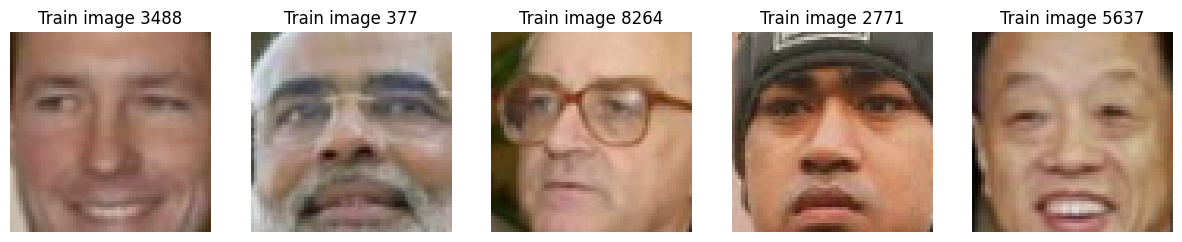

In [8]:
num_imgs = 5

fig, axes = plt.subplots(1, num_imgs, figsize=(15, 3))
print('Train datasate shape:', train_data.shape)

for i in range(num_imgs):
    k = np.random.randint(0, train_data.shape[0])
    axes[i].imshow(train_data[k])
    axes[i].axis('off')
    axes[i].set_title(f'Train image {k+1}')

Val datasate shape: (1972, 64, 64, 3)


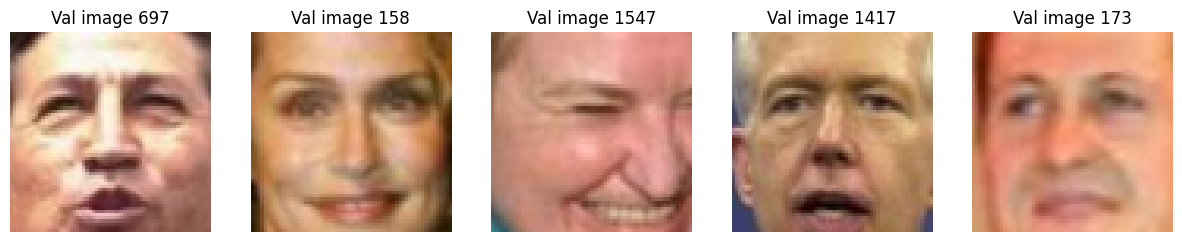

In [9]:
fig, axes = plt.subplots(1, num_imgs, figsize=(15, 3))
print('Val datasate shape:', val_data.shape)

for i in range(num_imgs):
    k = np.random.randint(0, val_data.shape[0])
    axes[i].imshow(val_data[k])
    axes[i].axis('off')
    axes[i].set_title(f'Val image {k+1}')

In [10]:
train_data = torch.tensor(train_data, dtype=torch.float)
val_data = torch.tensor(val_data, dtype=torch.float)

In [11]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=os.cpu_count()
                                          )
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=os.cpu_count()
                                        )

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



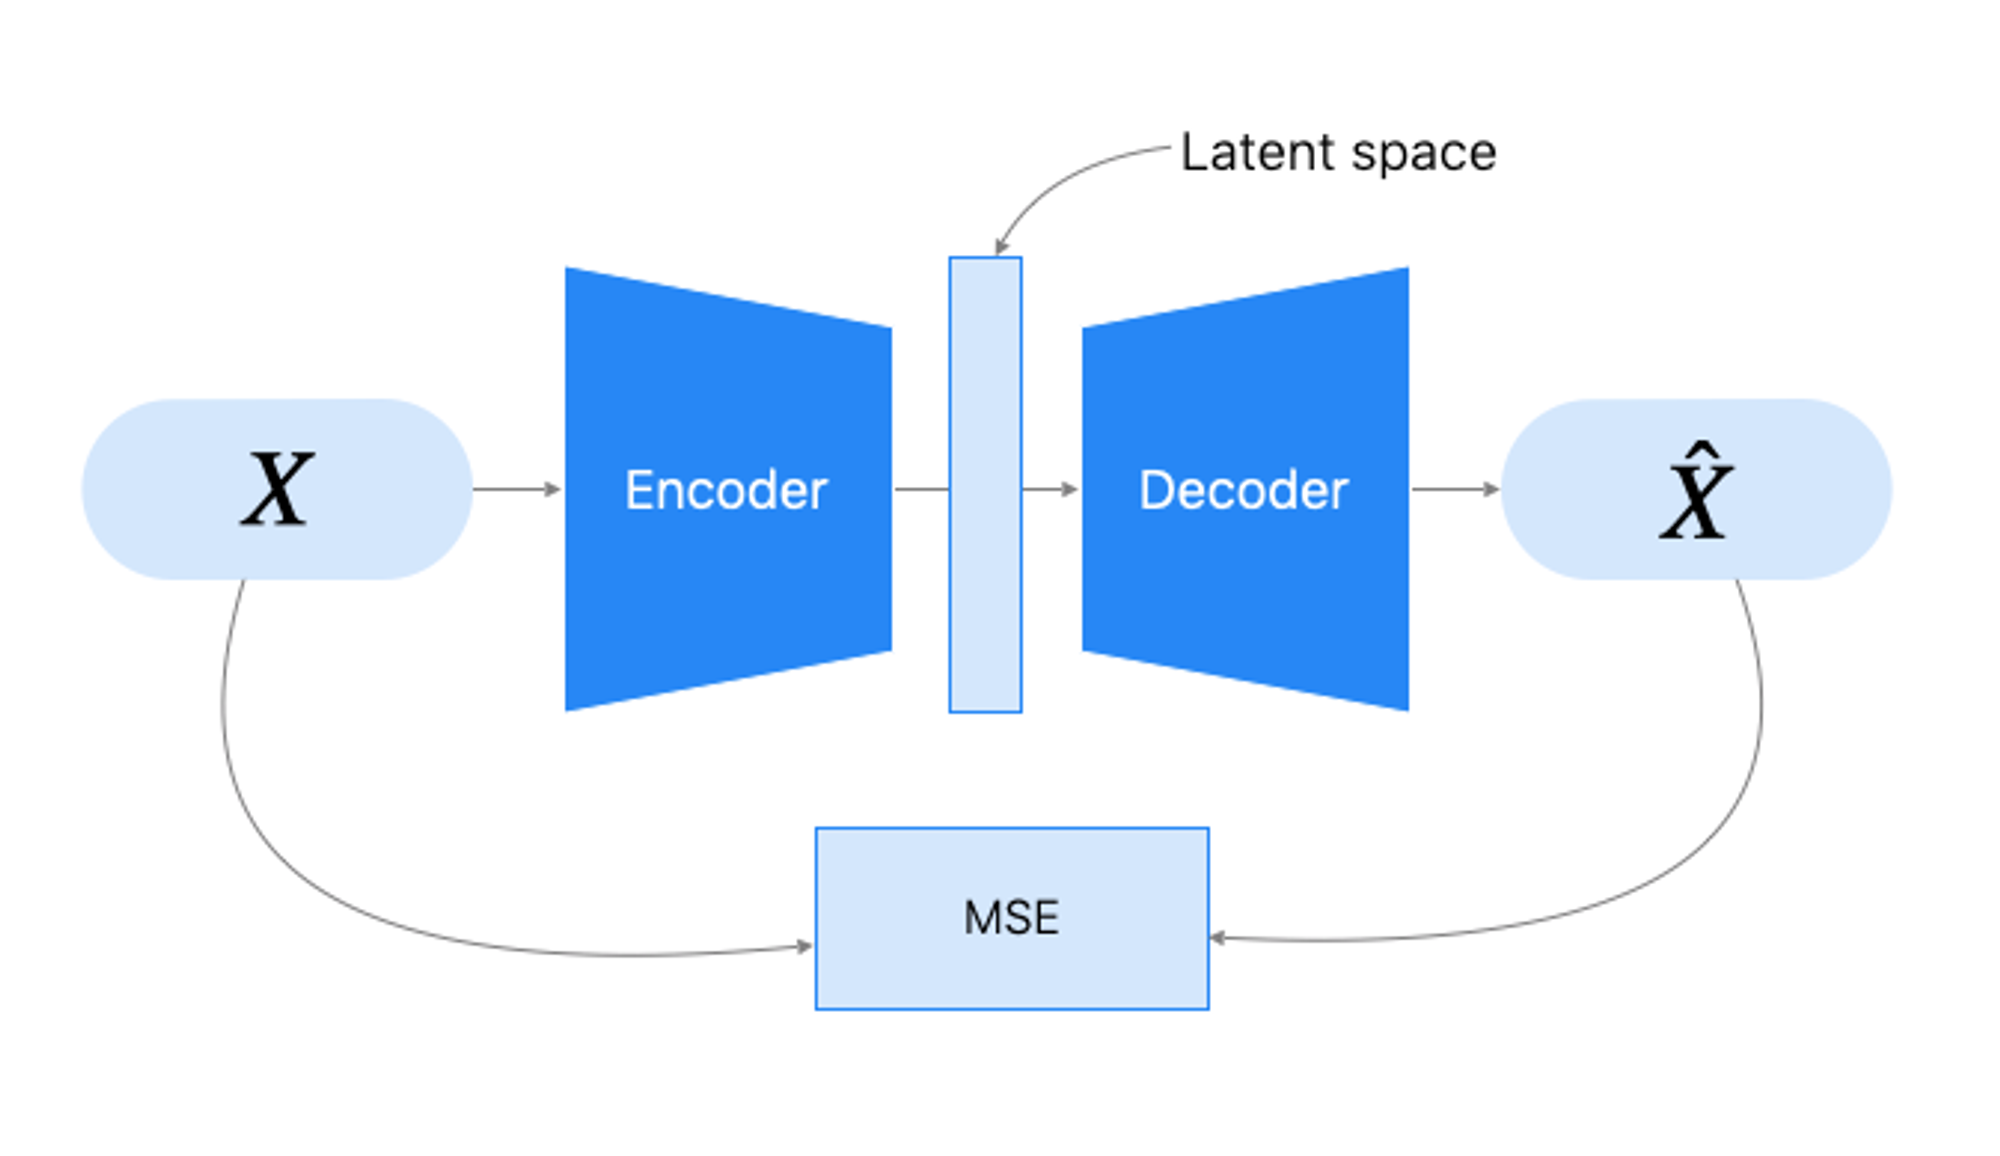


^ напомню, что автоэнкодер выглядит вот так

In [12]:
dim_code = 256

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_size),
            nn.ReLU()
        )
        

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(-1, 3, 64, 64)
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code).reshape(-1, 64, 64, 3)

        return reconstruction, latent_code

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [15]:
summary(Autoencoder(dim_code).to(device), (64, 64, 3), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
             ReLU-12                  [-1, 256]               0
           Linear-13                 [-1, 8192]       2,105,344
             ReLU-14                 [-

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [16]:
def train_model(
    train_epoch,
    val_epoch,
    plot_outputs_fn,
    plot_losses_fn,
    loaders,
    model,
    optim,
    loss_fn,
    device,
    n_epochs=40,
    lr=1e-3,
    steps_scheduler=None
):
    """
    Общая функция для тренировки моделей.
    
    Parameters
        ----------
        train_epoch : function
            Функция, отвечающая за тренировочную эпоху и возвращающая лосс.

        val_epoch : function
            Функция, отвечающая за валидационную эпоху.
            
        plot_outputs_fn: function
            Функция, отвечающая за отрисовку входных изображений и вывода модели.
            
        plot_losses_fn: function
            Функция, отвечающая за отрисовку графиков лоссов.

        loaders : list
            Список из 2 значений, первое - тренировочный лоадер, второе - валидационный.
        
        model : class
            Модель.
        
        optim: class
            Оптимайзер.
            
        device: str
            Cuda или cpu.
        
        loss_fn: class or function
            Функция потерь.
        
        n_epochs: int
            Количество эпох.
        
        lr: float
            Начальный шаг обучения.
            
        step_scheduler: None or list
            Если None, scheduler не используется. Если список, то он подается в MultiStepLR.
    """
    # Оптимайзер
    optimizer = optim(model.parameters(), lr)
    
    # Лоадеры
    train_loader = loaders[0]
    val_loader = loaders[1]
    
    # Шедулер
    if steps_scheduler:
        scheduler = MultiStepLR(optimizer, milestones=steps_scheduler, gamma=0.1)
    
    # Лоссы
    train_losses = []
    val_losses = []
    
    # Замер времени
    global_start = time.time()
    epoch_times = []
    
    # Чекпоинты
    best_val_loss = np.Inf
    best_epoch = 0
    best_model_wts = None

    for epoch in range(n_epochs):
        epoch_start = time.time()
        
        # Тренировка
        model.train()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            loss_fn,
            device
        )
        train_losses.append(train_loss)
        
        # Валидация
        model.eval()
        val_loss, last_batch, last_rec = val_epoch(
            model,
            val_loader,
            loss_fn,
            device
        )
        val_losses.append(val_loss)
        
        # Step шедулера
        if steps_scheduler:
            scheduler.step()
        
        # Создание чекпоинта    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_wts = deepcopy(model.state_dict())
            
        # Подсчёт времени    
        epoch_end = time.time()
        global_passed = epoch_end - global_start
        epoch_times.append(epoch_end - epoch_start)
        time_mean = np.mean(epoch_times)
        
        # Отрисовка вывода модеи
        plot_outputs_fn(
            last_batch,
            last_rec,
            epoch,
            n_epochs,
            train_loss,
            val_loss,
            global_passed,
            time_mean
        )
        
        # Отрисовка графика лоссов
        plot_losses_fn(train_losses, val_losses, best_val_loss, best_epoch)
    
    # Загрузка весов с чекпоинта и возвращение модели и лоссов
    model.load_state_dict(best_model_wts)
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

In [17]:
def plot_outputs(
    last_batch,
    last_rec,
    epoch,
    n_epochs,
    train_loss,
    val_loss,
    global_passed,
    time_mean
):
    clear_output(wait=True)
    plt.figure(figsize=(15, 10))
    for k in range(5):
        plt.subplot(3, 5, k+1)
        plt.imshow(last_batch[k])
        plt.title('Val image')
        plt.axis('off')

        plt.subplot(3, 5, k+6)
        plt.imshow(last_rec[k])
        plt.title('Output')
        plt.axis('off')


    plt.suptitle((
        f'Epochs: {epoch + 1} / {n_epochs}\n'
        f'[{"/" * (epoch + 1)}{"." * (n_epochs - epoch - 1)} ]\n'
        f'Time passed: {global_passed:.2f} s,  Per epoch: {time_mean:.2f} s,  '
        f'Estimated time left: {(n_epochs-epoch-1)*time_mean:.2f} s\n'
        f'Train loss: {train_loss:.8f}, Validation loss: {val_loss:.8f}'
        )
    )
    plt.show()
    
def plot_losses(train_losses, val_losses, best_val_loss, best_epoch):
    plt.figure(figsize=(15, 6))
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Val loss")
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Loss')
    plt.axvline(
        x=best_epoch,
        color='red',
        linestyle='--',
        label=f'Best val loss {best_val_loss:.6f}'
    )
    plt.legend(loc='upper center')
    plt.show()

In [18]:
def train_epoch_ae(model, train_loader, optimizer, loss_fn, device):
    train_losses_per_epoch = []
    for X_batch in tqdm_notebook(train_loader, desc='Train', leave=False):
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        reconstructed, _ = model(X_batch)
        loss = loss_fn(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def val_epoch_ae(model, val_loader, loss_fn, device):
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in tqdm_notebook(val_loader, desc='Validation', leave=False):
            X_batch = X_batch.to(device)
            reconstructed, _ = model(X_batch)
            loss = loss_fn(reconstructed, X_batch)
            val_losses_per_epoch.append(loss.item())
    return (
        np.mean(val_losses_per_epoch),
        X_batch.detach().cpu().numpy(),
        reconstructed.detach().cpu().numpy()
    )

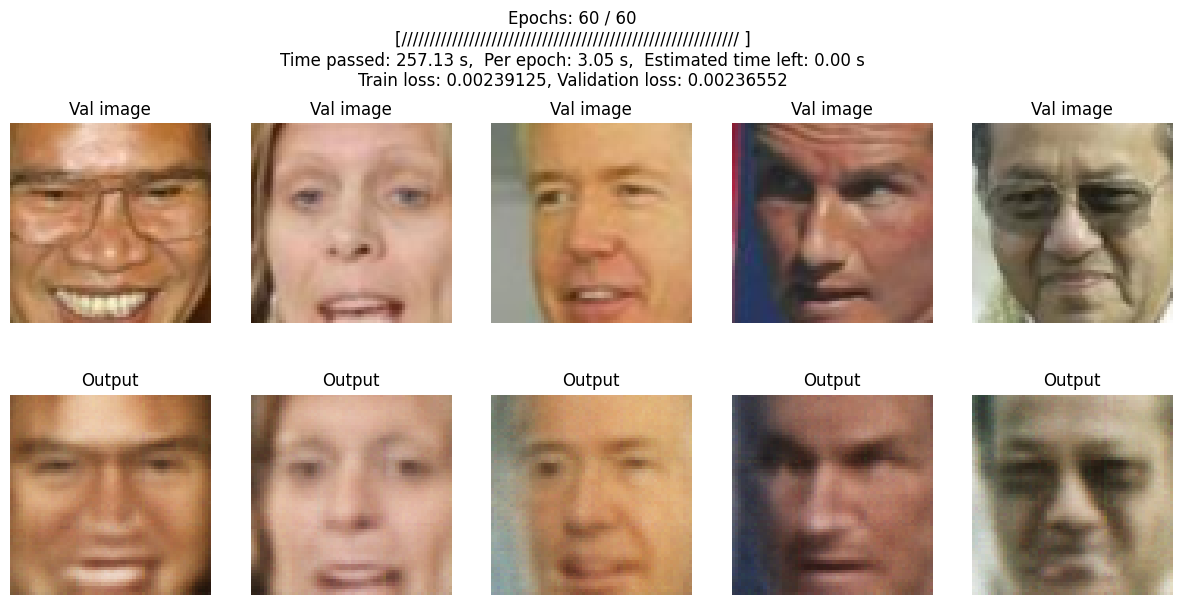

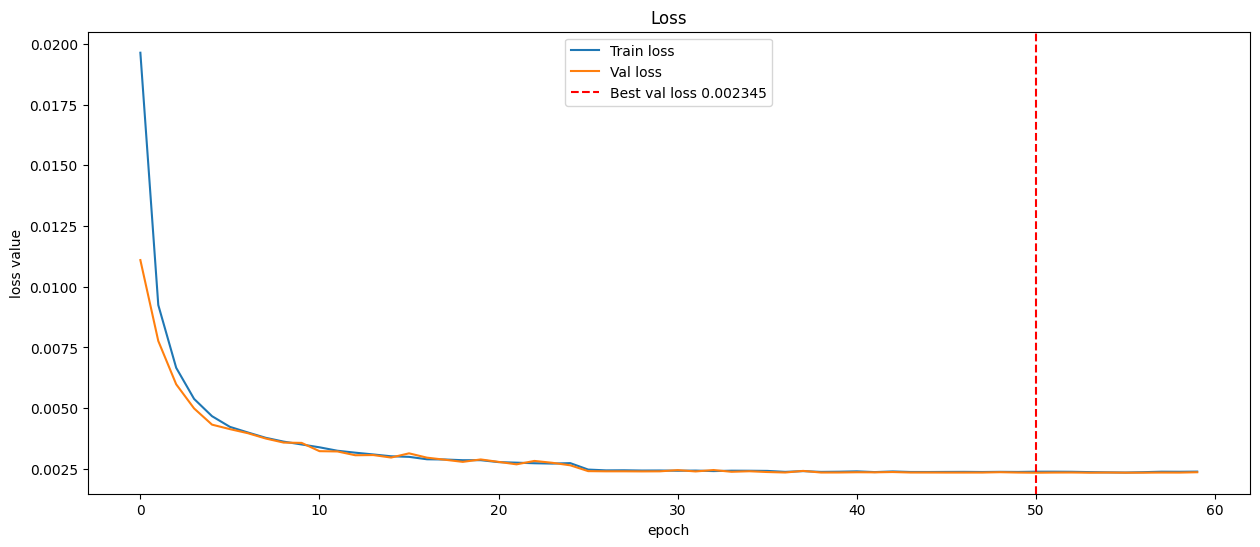

In [19]:
ae = Autoencoder(dim_code).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW
ae, losses_ae = train_model(
    train_epoch_ae,
    val_epoch_ae,
    plot_outputs,
    plot_losses,
    [train_loader, val_loader],
    ae,
    optimizer,
    criterion,
    device,
    n_epochs=60,
    lr=1e-3,
    steps_scheduler=[25, 36, 50]
)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

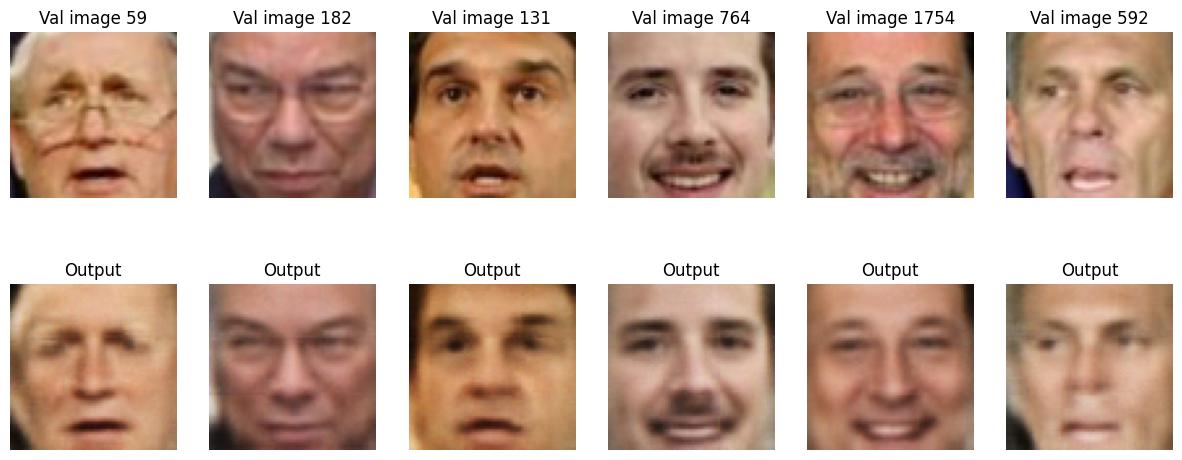

In [20]:
num_imgs = 6

fig, axes = plt.subplots(2, num_imgs, figsize=(15, 6))
ae.eval()
for i in range(num_imgs):
    k = np.random.randint(0, val_data.shape[0])
    img = val_data[k]
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Val image {k+1}')
    
    with torch.no_grad():
        rec, _ = ae(img.to(device))
    
    axes[1, i].imshow(rec[0].detach().cpu())
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Output')

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

Если брать просто векторы из нормального стандартного распределения, то получается просто шум, так что не буду здесь его выводить, сразу перейдем к изменению векторов.

In [21]:
ae.eval()
latents = torch.tensor([])
with torch.no_grad():
    for X_batch in tqdm_notebook(train_loader):
        latent = ae.encoder(X_batch.to(device).reshape(-1, 3, 64, 64))
        latents = torch.cat((latents, latent.detach().cpu()))

  0%|          | 0/175 [00:00<?, ?it/s]

In [22]:
latent_mu = latents.mean(0).unsqueeze(0)
latent_std = latents.std(0).unsqueeze(0)
print(latent_mu.shape, latent_std.shape)

torch.Size([1, 256]) torch.Size([1, 256])


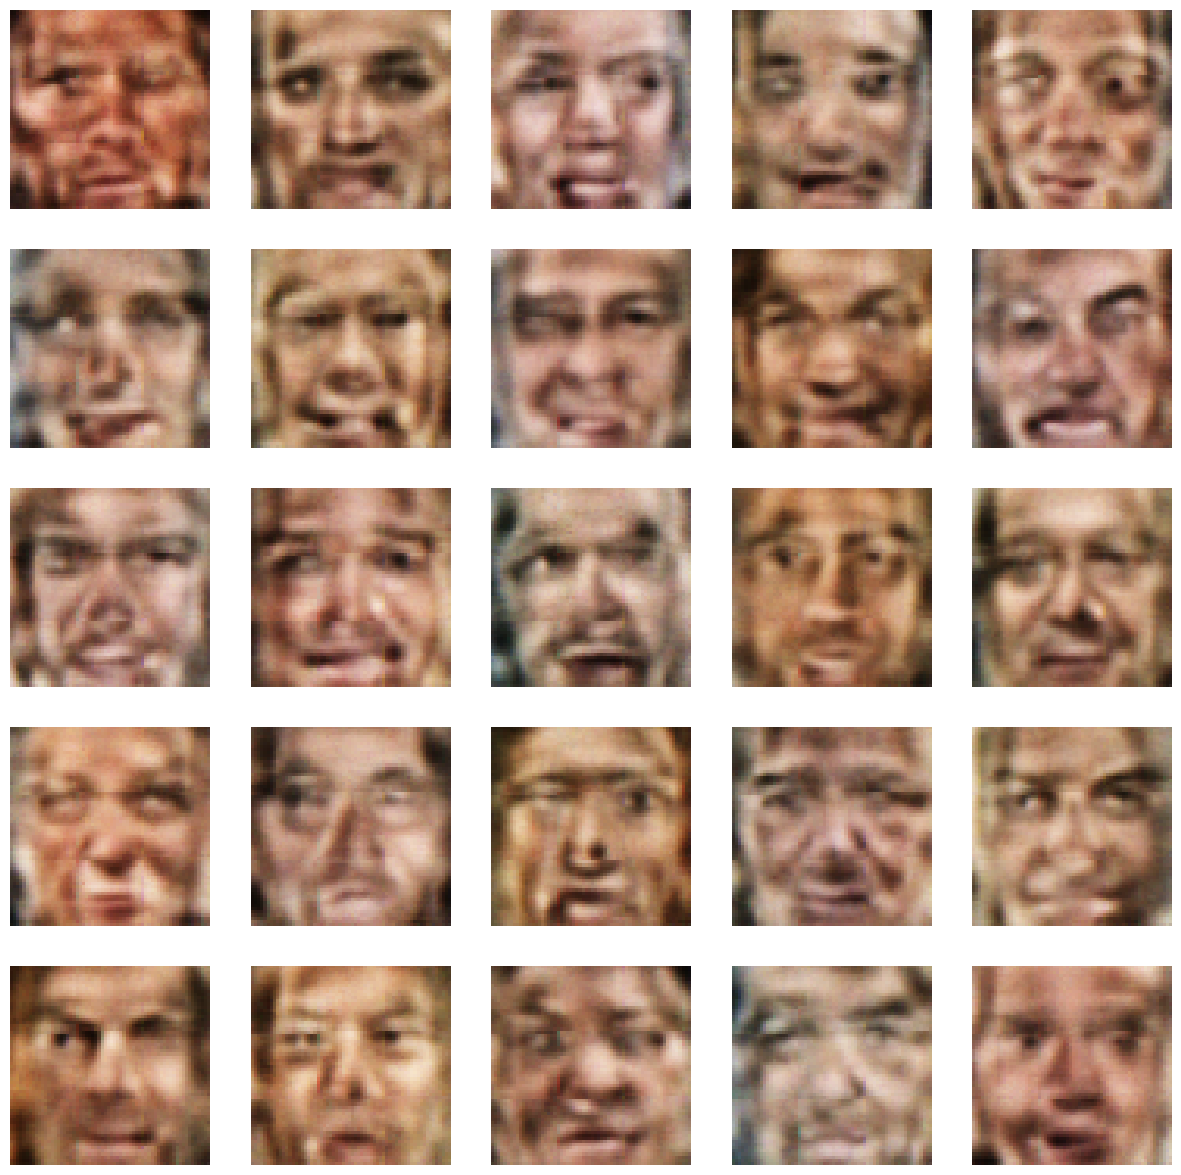

In [23]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, dim_code)
z = latent_mu + (z * latent_std)
ae.eval()
with torch.no_grad():
    output = ae.decoder(z.float().to(device))

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()
for i, rec in enumerate(output):
    axes[i].imshow(rec.reshape(64, 64, 3).detach().cpu().numpy())
    axes[i].axis('off')

Можно спокойно открывать второй thispersondoesntexist :)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

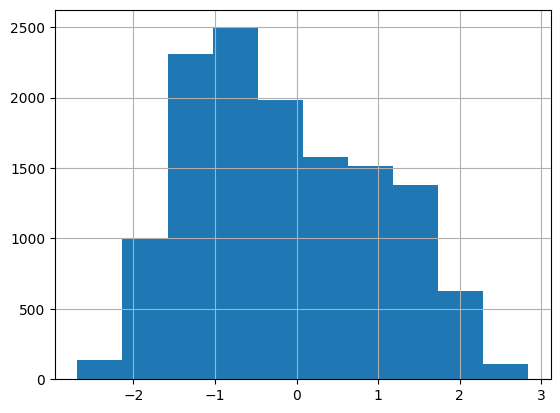

In [24]:
attrs.Smiling.hist();

In [25]:
smiling_people = attrs[attrs.Smiling > 2.1].sample(20).index
sad_people = attrs[attrs.Smiling < -2.1].sample(20).index

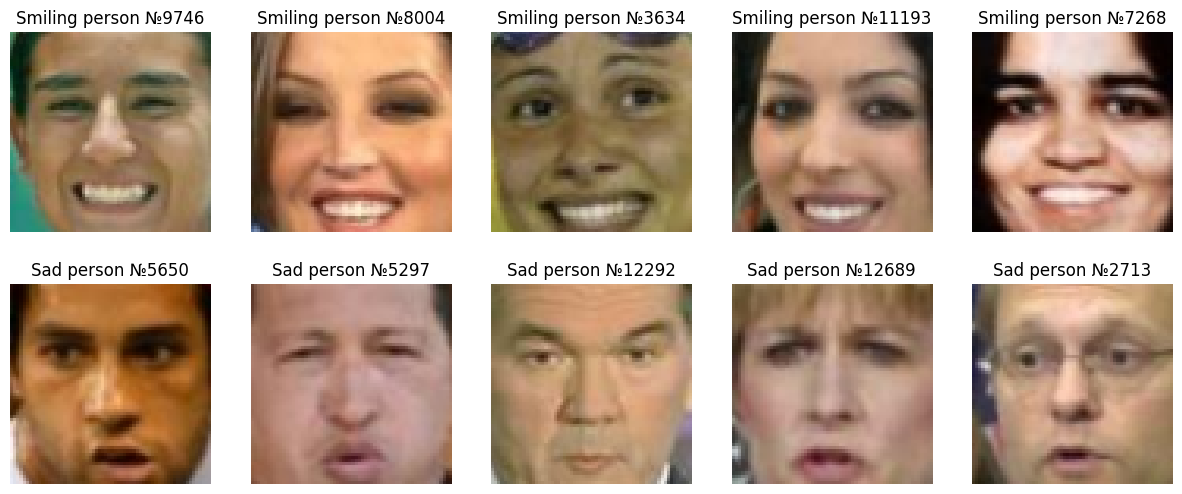

In [26]:
num_imgs = 5
fig, axes = plt.subplots(2, num_imgs, figsize=(15, 6))
sm = np.random.choice(smiling_people, size=num_imgs, replace=False)
sad = np.random.choice(sad_people, size=num_imgs, replace=False)
for i, (sm_id, sad_id) in enumerate(zip(sm, sad)):
    axes[0, i].imshow(data[sm_id])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Smiling person №{sm_id + 1}')
    
    axes[1, i].imshow(data[sad_id])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Sad person №{sad_id + 1}')

In [27]:
data_tensor = torch.tensor(data, dtype=torch.float)

In [28]:
data_tensor[smiling_people].shape

torch.Size([20, 64, 64, 3])

In [29]:
ae.eval()
with torch.no_grad():
    lat_smiling = ae.encoder(data_tensor[smiling_people].reshape(-1, 3, 64, 64).to(device)).cpu().numpy()
    lat_sad = ae.encoder(data_tensor[sad_people].reshape(-1, 3, 64, 64).to(device)).cpu().numpy()

In [30]:
lat_smiling_vector = np.mean(lat_smiling, axis=0)
lat_sad_vector = np.mean(lat_sad, axis=0)

smile_vector = lat_smiling_vector - lat_sad_vector

lat_sad_to_smiling = lat_sad + smile_vector
lat_sad_to_smiling = torch.tensor(lat_sad_to_smiling, dtype=torch.float)

with torch.no_grad():
    rec_sad_to_smiling = ae.decoder(lat_sad_to_smiling.to(device)).cpu().numpy().reshape(-1, 64, 64, 3)

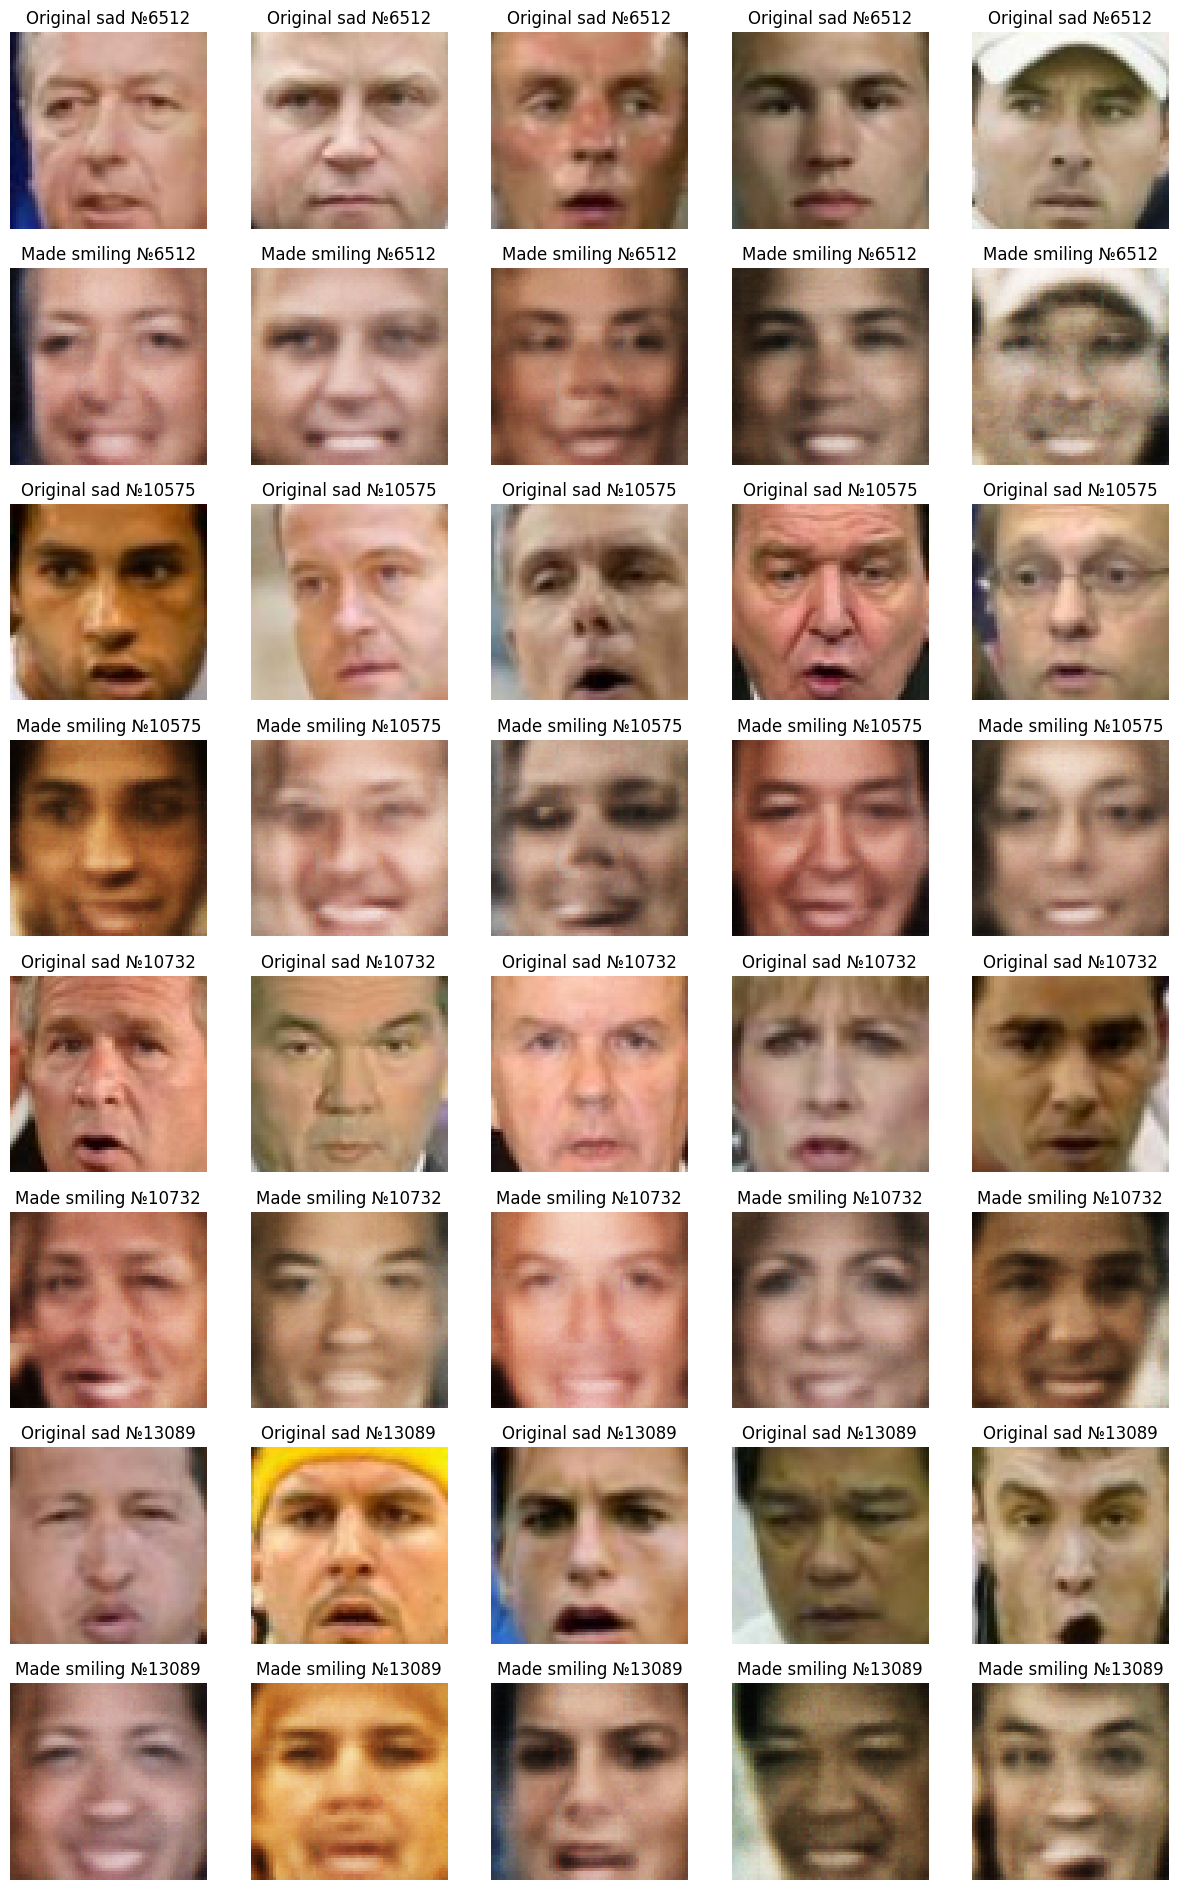

In [31]:
fig, axes = plt.subplots(8, 5, figsize=(15, 24))
for i in range(4):
    for j in range(5):
        k = j + i * 5
        sad_original = data[sad_people[k]]
        forced_to_smile = rec_sad_to_smiling[k]
        axes[2 * i, j].imshow(sad_original)
        axes[2 * i, j].axis('off')
        axes[2 * i, j].set_title(f'Original sad №{sad_people[i]}')

        axes[2 * i + 1, j].imshow(forced_to_smile)
        axes[2 * i + 1, j].axis('off')
        axes[2 * i + 1, j].set_title(f'Made smiling №{sad_people[i]}')
    
    
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [32]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.Compose(
                                   [transforms.ToImageTensor(), transforms.ConvertImageDtype()]
                               ),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.Compose(
                                  [transforms.ToImageTensor(), transforms.ConvertImageDtype()]
                              ),
                              download=False)

# Data Loader (Input Pipeline)
train_loader_mnist = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader_mnist = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 352665291.75it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44226248.20it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 209693199.01it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17477549.33it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [33]:
print('Train:', train_dataset.data.shape)
print('Test:', test_dataset.data.shape)

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


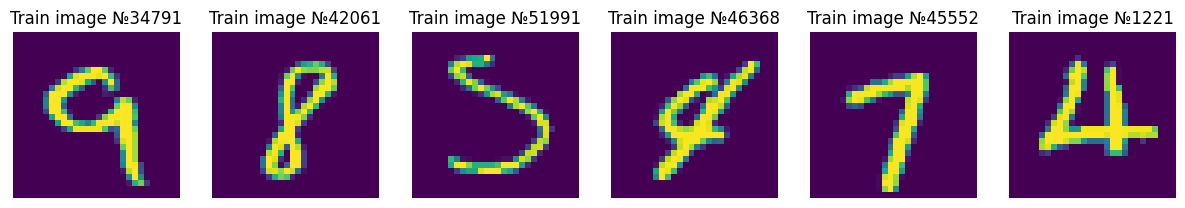

In [34]:
num_imgs = 6
rnd_train = np.random.randint(0, train_dataset.data.shape[0], size=num_imgs)
fig, axes = plt.subplots(1, num_imgs, figsize=(15, 4))
for i, idx in enumerate(rnd_train):
    axes[i].imshow(train_dataset[idx][0].squeeze(0)) # 1, 28, 28 - > 28, 28; reshape(28, 28, 1)
    axes[i].axis('off')
    axes[i].set_title(f'Train image №{idx + 1}')

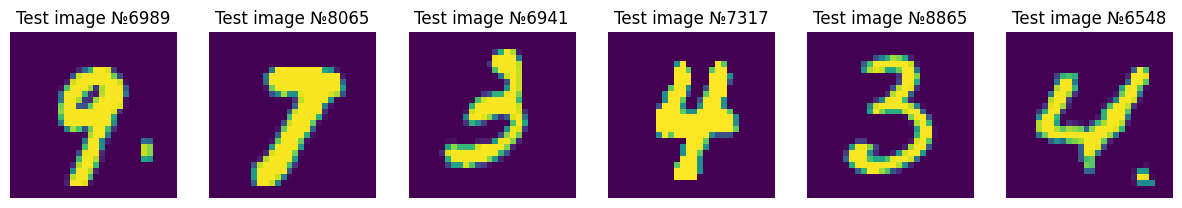

In [35]:
rnd_test = np.random.randint(0, test_dataset.data.shape[0], size=num_imgs)
fig, axes = plt.subplots(1, num_imgs, figsize=(15, 4))
for i, idx in enumerate(rnd_test):
    axes[i].imshow(test_dataset[idx][0].squeeze(0))
    axes[i].axis('off')
    axes[i].set_title(f'Test image №{idx + 1}')

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [36]:
class VAE(nn.Module):
    def __init__(self, latent_dim, input_dim=1, img_size=28):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, kernel_size=3, stride=1, padding=1), # 28, 28 -> 28, 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # 28, 28 -> 28, 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 28, 28 -> 14, 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 14, 14 -> 14, 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14, 14 -> 7, 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # 7, 7 -> 7, 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (img_size**2 // 16), latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (img_size**2 // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (64, img_size // 4, img_size // 4)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),  # 7, 7 -> 7, 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7, 7 -> 14, 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),  # 14, 14 -> 14, 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14, 14 -> 28, 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),  # 28, 28 -> 28, 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_dim, kernel_size=3, stride=1, padding=1),  # 28, 28 -> 28, 28
            nn.Sigmoid()
        )
        
    def encode(self, x):
        mu, logsigma = torch.split(self.encoder(x), self.latent_dim, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            sample = torch.randn_like(std)
            sample = std * sample + mu
        else:
            sample = mu
        return sample

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [37]:
summary(VAE(32).to(device), (1, 28, 28), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 28, 28]             160
       BatchNorm2d-2           [64, 16, 28, 28]              32
              ReLU-3           [64, 16, 28, 28]               0
            Conv2d-4           [64, 16, 28, 28]           2,320
       BatchNorm2d-5           [64, 16, 28, 28]              32
              ReLU-6           [64, 16, 28, 28]               0
            Conv2d-7           [64, 32, 14, 14]           4,640
       BatchNorm2d-8           [64, 32, 14, 14]              64
              ReLU-9           [64, 32, 14, 14]               0
           Conv2d-10           [64, 32, 14, 14]           9,248
      BatchNorm2d-11           [64, 32, 14, 14]              64
             ReLU-12           [64, 32, 14, 14]               0
           Conv2d-13             [64, 64, 7, 7]          18,496
      BatchNorm2d-14             [64, 6

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [38]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss =  (-0.5) * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x) / x.shape[0]

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [39]:
def train_epoch_vae(model, train_loader, optimizer, loss_fn, device):
    train_losses_per_epoch = []
    for X_batch, _ in tqdm_notebook(train_loader, desc='Train', leave=False):
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        mu, logsigma, rec = model(X_batch)
        loss = loss_fn(X_batch, mu, logsigma, rec)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def val_epoch_vae(model, val_loader, loss_fn, device):
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, _ in tqdm_notebook(val_loader, desc='Validation', leave=False):
            X_batch = X_batch.to(device)
            mu, logsigma, rec = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, rec)
            val_losses_per_epoch.append(loss.item())
    return (
        np.mean(val_losses_per_epoch),
        X_batch.detach().cpu().numpy().squeeze(1),
        rec.detach().cpu().numpy().squeeze(1)
    )

И обучим модель:

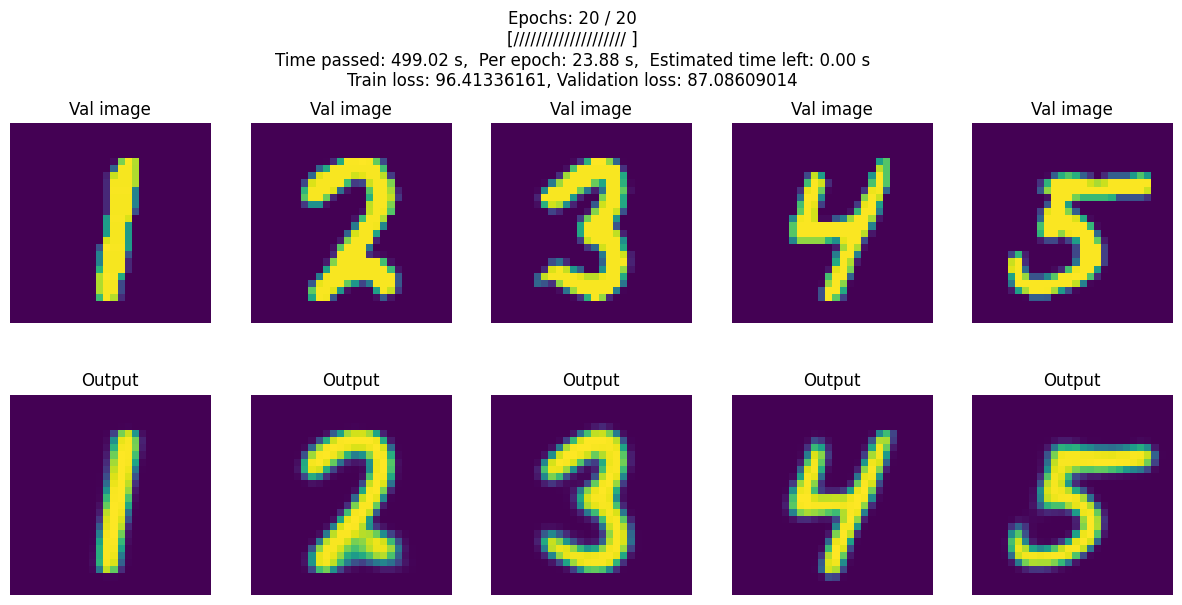

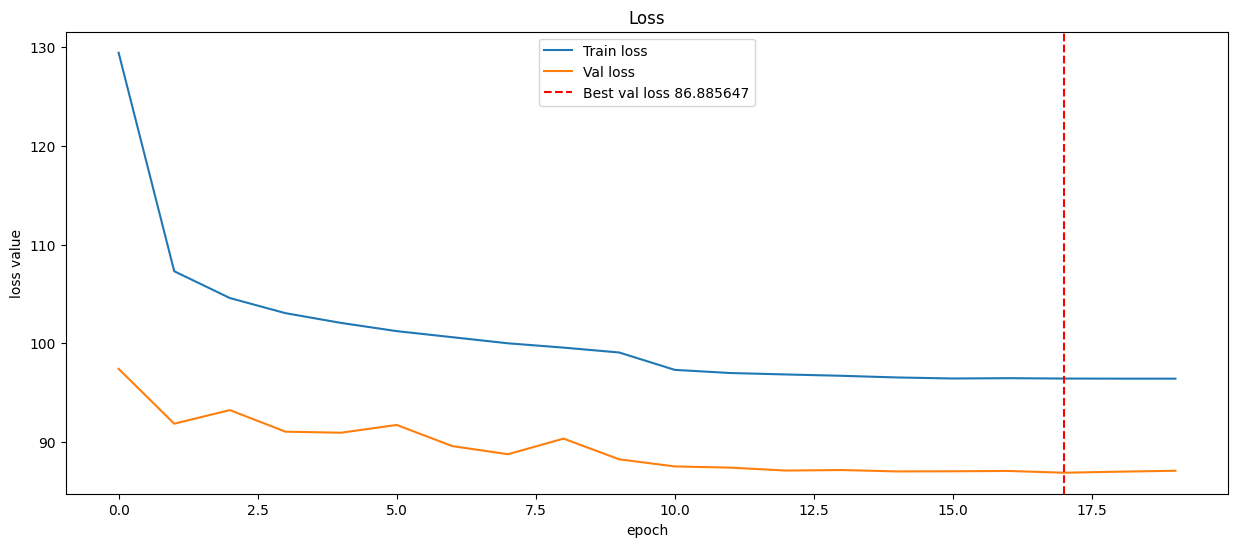

In [40]:
vae_dim = 32
vae = VAE(vae_dim).to(device)
criterion = loss_vae
optimizer = optim.AdamW
vae, losses_vae = train_model(
    train_epoch_vae,
    val_epoch_vae,
    plot_outputs,
    plot_losses,
    [train_loader_mnist, test_loader_mnist],
    vae,
    optimizer,
    criterion,
    device,
    n_epochs=20,
    lr=1e-3,
    steps_scheduler=[10, 14, 18]
)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

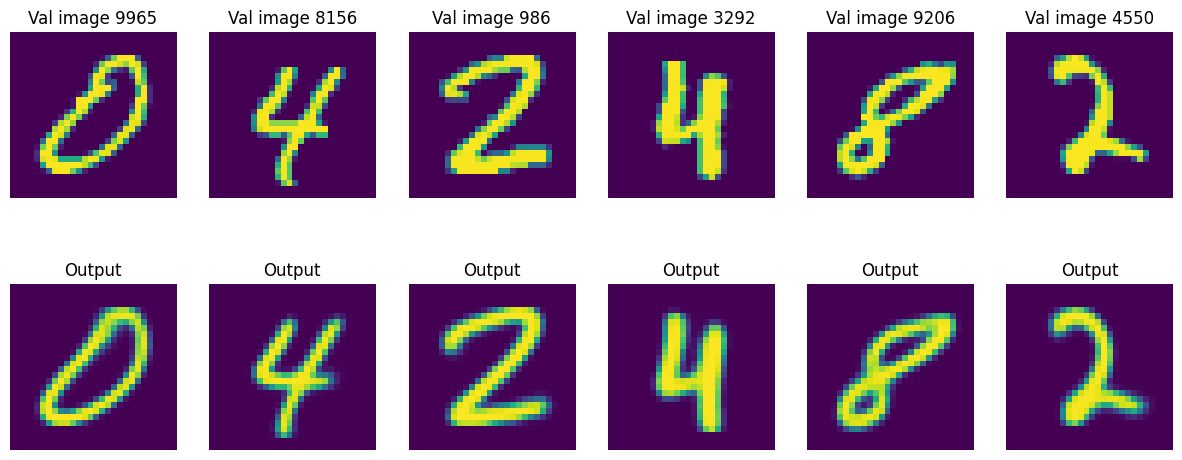

In [41]:
num_imgs = 6

fig, axes = plt.subplots(2, num_imgs, figsize=(15, 6))
vae.eval()
for i in range(num_imgs):
    k = np.random.randint(0, test_dataset.data.shape[0])
    img, _ = test_dataset[k]
    axes[0, i].imshow(img.squeeze(0))
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Val image {k+1}')
    
    with torch.no_grad():
        _, _, rec = vae(img.unsqueeze(0).to(device))
    
    axes[1, i].imshow(rec.squeeze(0, 1).detach().cpu().numpy())
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Output')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

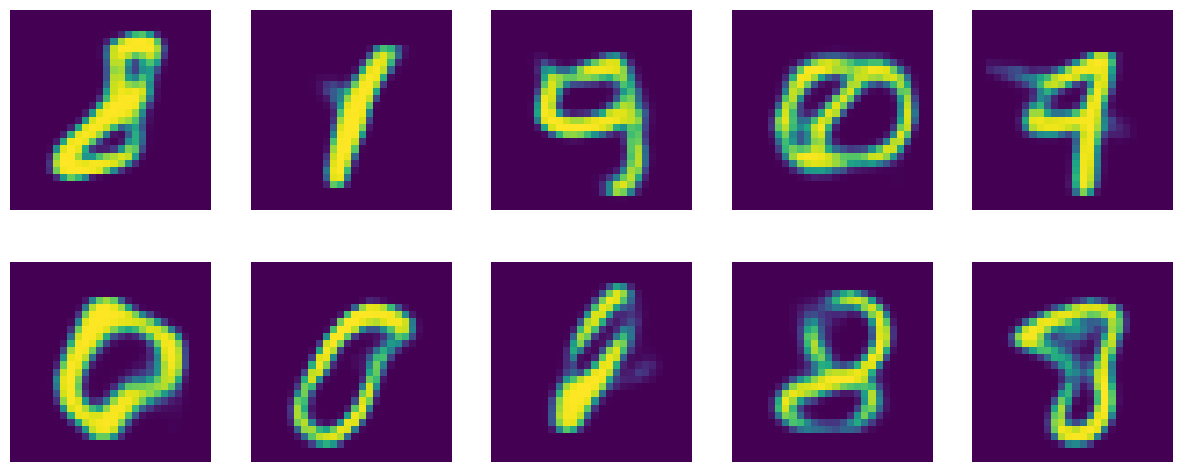

In [42]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, vae_dim) for i in range(10)])
vae.eval()
with torch.no_grad():
    output = vae.decode(torch.tensor(z, dtype=torch.float).to(device)).detach().cpu().numpy()
    
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(output[i].squeeze(0))
    axes[i].axis('off')
    
plt.show()

В этот раз из стандартного нормального распределения картинки получились хорошие, в отличие от шума для ванильного автоэнкодера, числа на них более-менее различимы.

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [43]:
labels = torch.tensor([])
lat_vectors = torch.tensor([])

# Получим латентные представление картинок (цифр) тестового датасета
vae.eval()
with torch.no_grad():
    for X, label in tqdm_notebook(test_loader_mnist):
        lat_vector, _ = vae.encode(X.to(device))
        lat_vectors = torch.cat((lat_vectors, lat_vector.detach().cpu()))
        labels = torch.cat((labels, label))

print('Labels shape:', labels.shape)
print('Latent vectors shape:', lat_vectors.shape)

  0%|          | 0/157 [00:00<?, ?it/s]

Labels shape: torch.Size([10000])
Latent vectors shape: torch.Size([10000, 32])


In [44]:
embedded_lat_vectors = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=seed,
    n_jobs=-1
).fit_transform(lat_vectors.numpy())

print('Low dimensional TSNE embedding of latent vectors:', embedded_lat_vectors.shape)

Low dimensional TSNE embedding of latent vectors: (10000, 2)


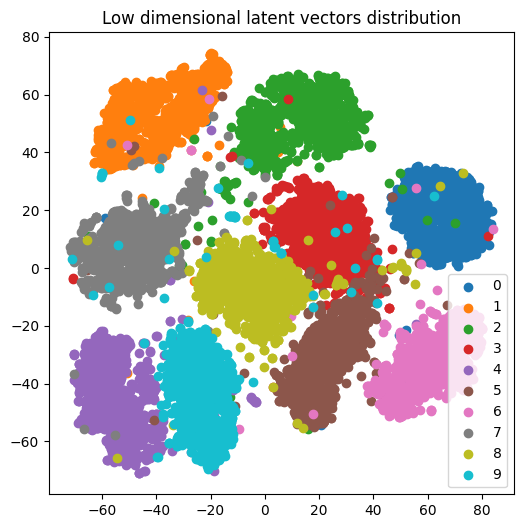

In [45]:
labels = labels.int().numpy()
plt.figure(figsize=(6, 6))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(
        embedded_lat_vectors[mask][:, 0],
        embedded_lat_vectors[mask][:, 1],
        label=str(label)
    )
plt.title('Low dimensional latent vectors distribution')
plt.legend()
plt.show()

Что вы думаете о виде латентного представления?

На графике четко видны кластеры разных цифр. Это говорит о том, что и в латентном просранстве VAE, скорее всего, цифры хорошо разделены. Также похожие по написанию цифры находятся близко друг к другу (например, 8 и 3, 8 и 9, 4 и 9 и т. д.).

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [46]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, input_dim=1, num_labels=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.nlabels = num_labels

        self.encoder = nn.Sequential(
            nn.Linear((num_labels + 28 * 28), 128 * 4),
            nn.BatchNorm1d(128 * 4),
            nn.ReLU(),
            nn.Linear(128 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear((num_labels + latent_dim), 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128 * 4),
            nn.BatchNorm1d(128 * 4),
            nn.ReLU(),
            nn.Linear(128 * 4, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        mu, logsigma = torch.split(self.encoder(self.add_ohe(x, labels)), self.latent_dim, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            sample = torch.randn_like(std)
            sample = std * sample + mu
        else:
            sample = mu
        return sample

    def decode(self, z, labels):
        reconstruction = self.decoder(self.add_ohe(z, labels))
        return reconstruction
    
    def add_ohe(self, images, labels):
        onehot_labels = torch.zeros(
            len(labels),
            self.nlabels
        ).scatter_(1, labels.unsqueeze(1), 1)
        
        res = torch.cat((onehot_labels.to(images.device), images), dim=1)
        return res

    def forward(self, x):
        images, labels = x
        
        images_shape = images.shape
        images = images.reshape(images_shape[0], -1)
        
        mu, logsigma = self.encode(images, labels)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, labels)
        
        return mu, logsigma, reconstruction.reshape(images_shape)

Картинки, конечно, немного сбивают с толку. Написано, что мы подаем картинку, сконкатенированную с onehot вектором в первый слой энкодера и декодера, на картинке же мы вектор конкатенируется перед подачей в латентное пространство.

Также не совсем понял, как сделать CVAE со сверточными слоями так, чтобы подавать информацию о классе и в энкодер, и в декодер, так что сделал линейный. Возможно, можно было бы как раз конкатенирировать не в начале, а после flatten в энкодере (как на картинке, по сути) и перед подачей в decoder.

In [47]:
# Как работает self.add_ohe()
torch.zeros(64, 10).scatter_(1, torch.randint(0, 10, (64,)).unsqueeze(1), 1)[:10]

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

Чтобы сделать сделать summary, скорее всего, надо подавать в модель уже сконкатенированные изображения с onehot векторами, иначе summary не рабтает.

### Training

In [48]:
def train_epoch_cvae(model, train_loader, optimizer, loss_fn, device):
    train_losses_per_epoch = []
    for X_batch in tqdm_notebook(train_loader, desc='Train', leave=False):
        X_batch[0] = X_batch[0].to(device)
        optimizer.zero_grad()
        mu, logsigma, rec = model(X_batch)
        loss = loss_fn(X_batch[0], mu, logsigma, rec)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def val_epoch_cvae(model, val_loader, loss_fn, device):
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in tqdm_notebook(val_loader, desc='Validation', leave=False):
            X_batch[0] = X_batch[0].to(device)
            mu, logsigma, rec = model(X_batch)
            loss = loss_fn(X_batch[0], mu, logsigma, rec)
            val_losses_per_epoch.append(loss.item())
    return (
        np.mean(val_losses_per_epoch),
        X_batch[0].detach().cpu().numpy().squeeze(1),
        rec.detach().cpu().numpy().squeeze(1)
    )

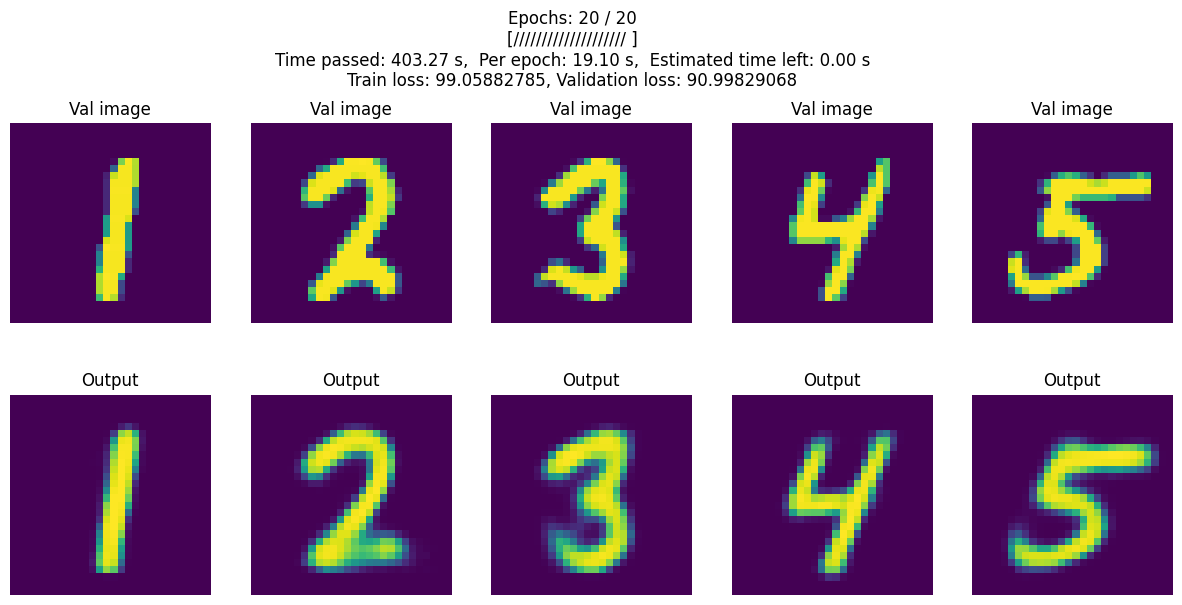

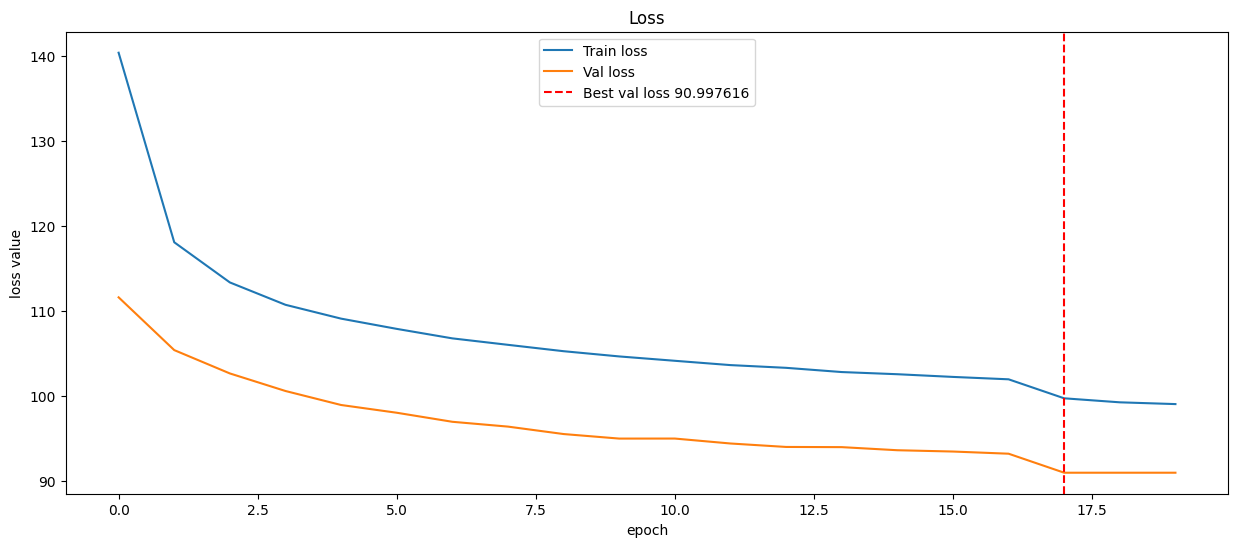

In [49]:
cvae_dim = 16
cvae = CVAE(cvae_dim).to(device)
optimizer = optim.AdamW
criterion = loss_vae
cvae, losses_cvae = train_model(
    train_epoch_cvae,
    val_epoch_cvae,
    plot_outputs,
    plot_losses,
    [train_loader_mnist, test_loader_mnist],
    cvae,
    optimizer,
    criterion,
    device,
    n_epochs=20,
    lr=1e-3,
    steps_scheduler=[17]
)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

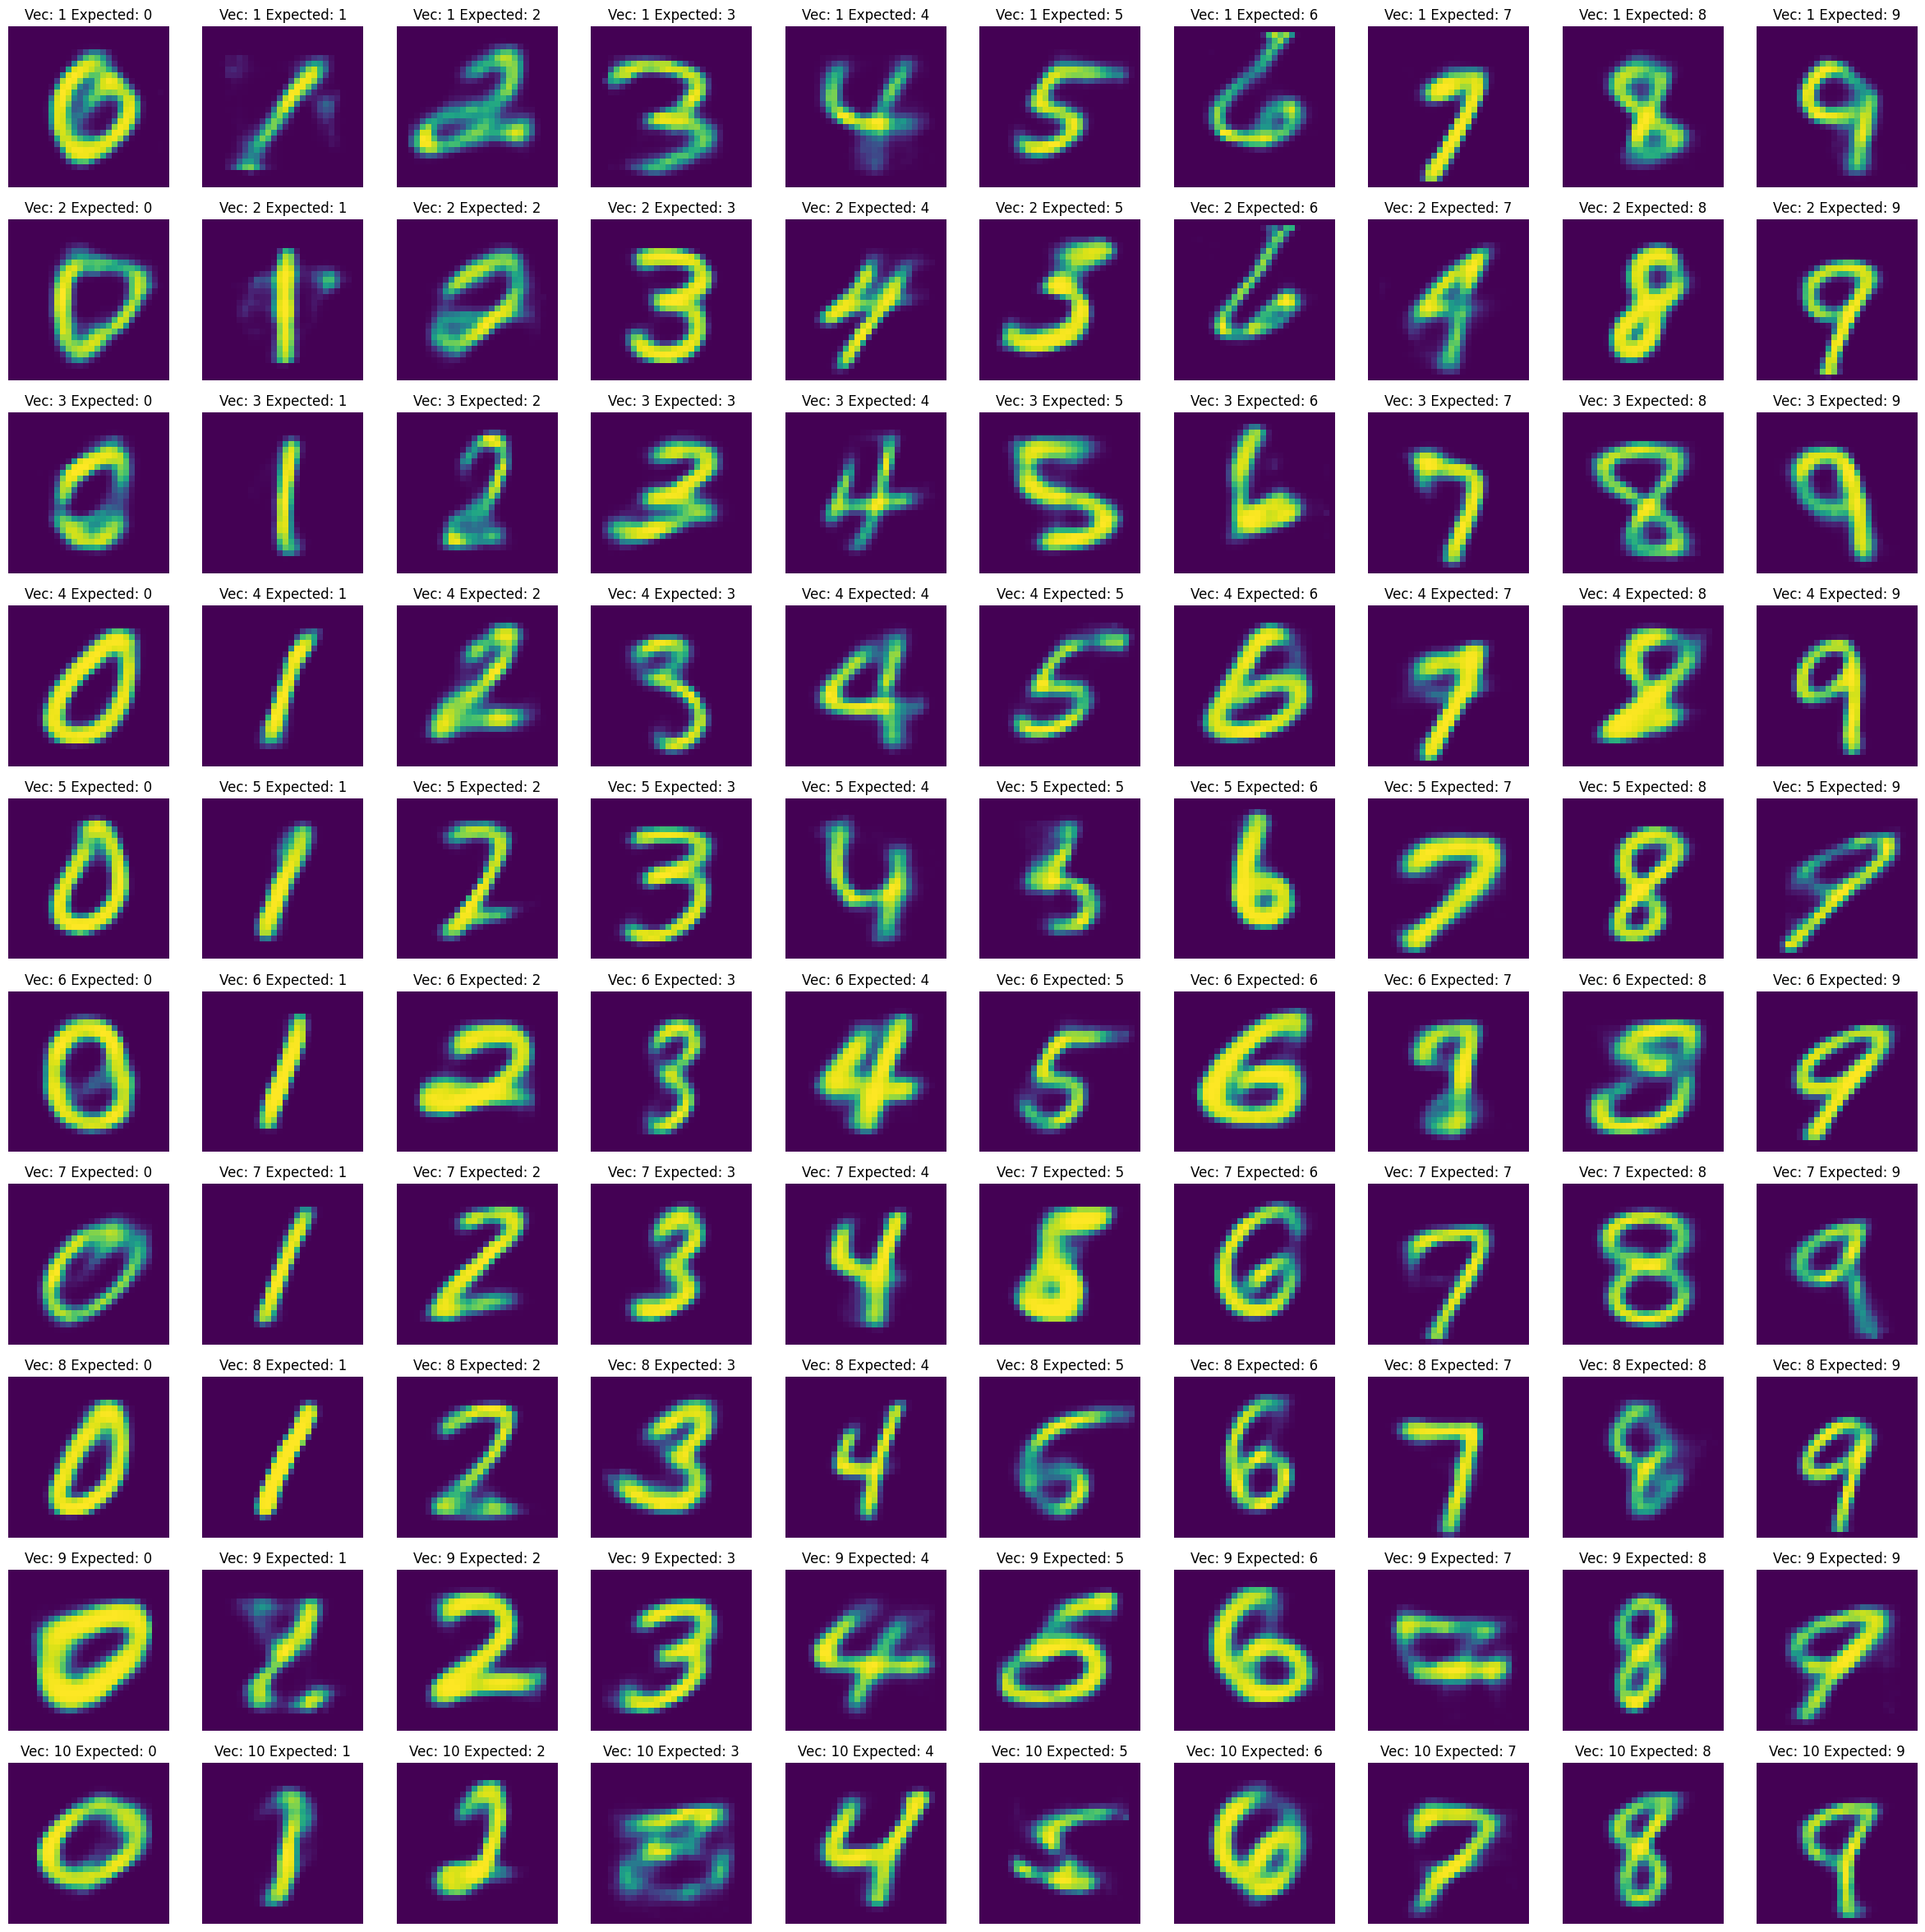

In [50]:
num_vecs = 10

labels = torch.cat(([torch.arange(0, 10)] * num_vecs))

z = torch.randn(num_vecs*10, cvae_dim)

cvae.eval()
with torch.no_grad():
    output = cvae.decode(z.to(device), labels).detach().cpu().reshape(-1, 28, 28).numpy()

    
fig, axes = plt.subplots(num_vecs, 10, figsize=(30, num_vecs*3))
axes = axes.flatten()
for i in range(num_vecs):
    for j in range(10):
        axes[i*10+j].imshow(output[i*10+j])
        axes[i*10+j].axis('off')
        axes[i*10+j].set_title(f'Vec: {i+1} Expected: {labels[i*10+j]}')
    
plt.show()

Какие-то векторы получились удачнее других, но, в целом, сетка выдает ожидаемые числа из одних и тех же векторов.

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [51]:
labels = torch.tensor([])
lat_vectors = torch.tensor([])

# Получим латентные представление картинок (цифр) тестового датасета
cvae.eval()
with torch.no_grad():
    for X, label in tqdm_notebook(test_loader_mnist):
        lat_vector, _ = cvae.encode(X.to(device).reshape(X.shape[0], -1), label)
        lat_vectors = torch.cat((lat_vectors, lat_vector.detach().cpu()))
        labels = torch.cat((labels, label))

print('Labels shape:', labels.shape)
print('Latent vectors shape:', lat_vectors.shape)

  0%|          | 0/157 [00:00<?, ?it/s]

Labels shape: torch.Size([10000])
Latent vectors shape: torch.Size([10000, 16])


In [52]:
embedded_lat_vectors = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=seed,
    n_jobs=-1
).fit_transform(lat_vectors.numpy())

print('Low dimensional TSNE embedding of latent vectors:', embedded_lat_vectors.shape)

Low dimensional TSNE embedding of latent vectors: (10000, 2)


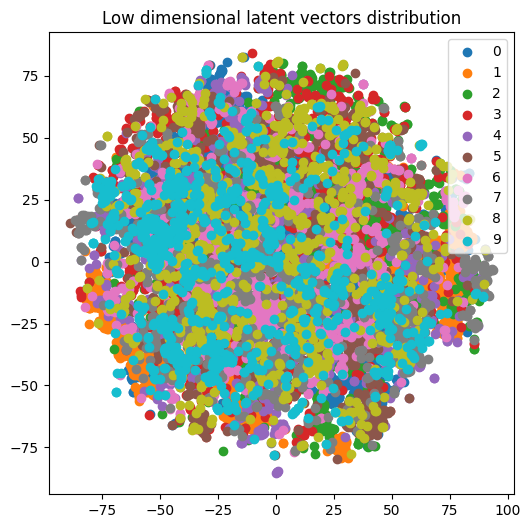

In [53]:
labels = labels.int().numpy()
plt.figure(figsize=(6, 6))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(
        embedded_lat_vectors[mask][:, 0],
        embedded_lat_vectors[mask][:, 1],
        label=str(label)
    )
plt.title('Low dimensional latent vectors distribution')
plt.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

В этом случае представления цифр +- равномерно распределены, кластер, по сути, только один, исходя из визуализации с помощью TSNE. Насколько я понимаю, в CVAE латентное пространство менее информативно, чем в VAE, из-за подачи onehot вектора в декодер.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [54]:
def train_epoch_denoising(model, train_loader, optimizer, loss_fn, device):
    train_losses_per_epoch = []
    for X_batch in tqdm_notebook(train_loader, desc='Train', leave=False):
        X_batch = X_batch.to(device)
        # Накладываем шум на изображение
        X_batch_noisy = X_batch + noise_factor * torch.randn_like(X_batch)
        optimizer.zero_grad()
        # Подаем в модель изображение с шумом
        reconstructed, _ = model(X_batch_noisy)
        # Лосс считаем по выводу модели и оригинальному изображению
        loss = loss_fn(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def val_epoch_denoising(model, val_loader, loss_fn, device):
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in tqdm_notebook(val_loader, desc='Validation', leave=False):
            X_batch = X_batch.to(device)
            # Накладываем шум на изображен
            X_batch_noisy = X_batch + noise_factor * torch.randn_like(X_batch)
            # Подаем в модель изображение с шумом
            reconstructed, _ = model(X_batch_noisy)
            # Лосс считаем по выводу модели и оригинальному изображению
            loss = loss_fn(reconstructed, X_batch)
            val_losses_per_epoch.append(loss.item())
    return (
        np.mean(val_losses_per_epoch),
        # В last_batch возвращаем кортеж из оригинального изображения и зашумленного
        (X_batch.detach().cpu().numpy(), X_batch_noisy.detach().cpu().numpy()),
        reconstructed.detach().cpu().numpy()
    )

Переписал plot_outputs, добавил вывод зашумленных изображений.

In [55]:
def plot_outputs_denoising(
    last_batch,
    last_rec,
    epoch,
    n_epochs,
    train_loss,
    val_loss,
    global_passed,
    time_mean
):
    clear_output(wait=True)
    plt.figure(figsize=(15, 10))
    # Распаковываем кортеж
    last_clear, last_noisy = last_batch
    for k in range(5):
        plt.subplot(3, 5, k+1)
        plt.imshow(last_clear[k])
        plt.title('Val image')
        plt.axis('off')
        
        plt.subplot(3, 5, k+6)
        plt.imshow(last_noisy[k])
        plt.title('Noisy image')
        plt.axis('off')

        plt.subplot(3, 5, k+11)
        plt.imshow(last_rec[k])
        plt.title('Output')
        plt.axis('off')


    plt.suptitle((
        f'Epochs: {epoch + 1} / {n_epochs}\n'
        f'[{"/" * (epoch + 1)}{"." * (n_epochs - epoch - 1)} ]\n'
        f'Time passed: {global_passed:.2f} s,  Per epoch: {time_mean:.2f} s,  '
        f'Estimated time left: {(n_epochs-epoch-1)*time_mean:.2f} s\n'
        f'Train loss: {train_loss:.8f}, Validation loss: {val_loss:.8f}'
        )
    )
    plt.show()

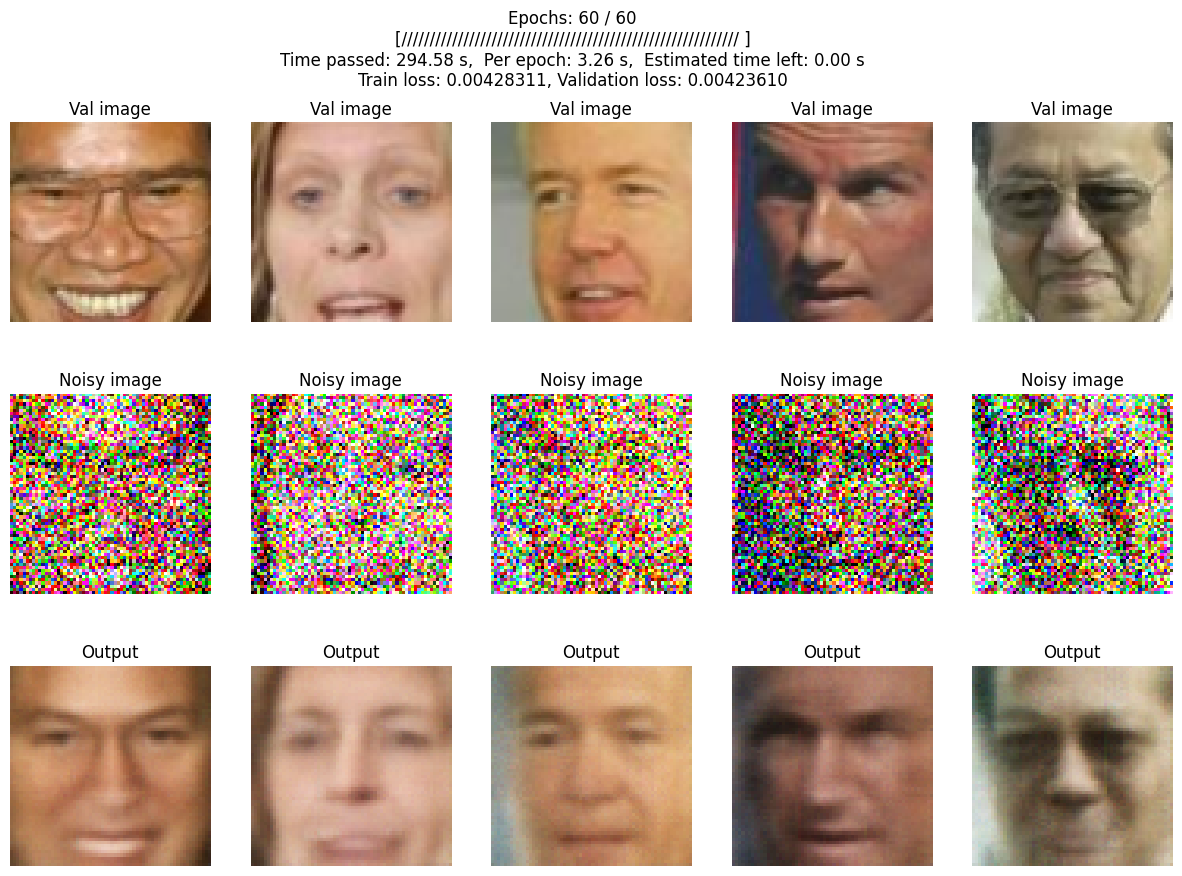

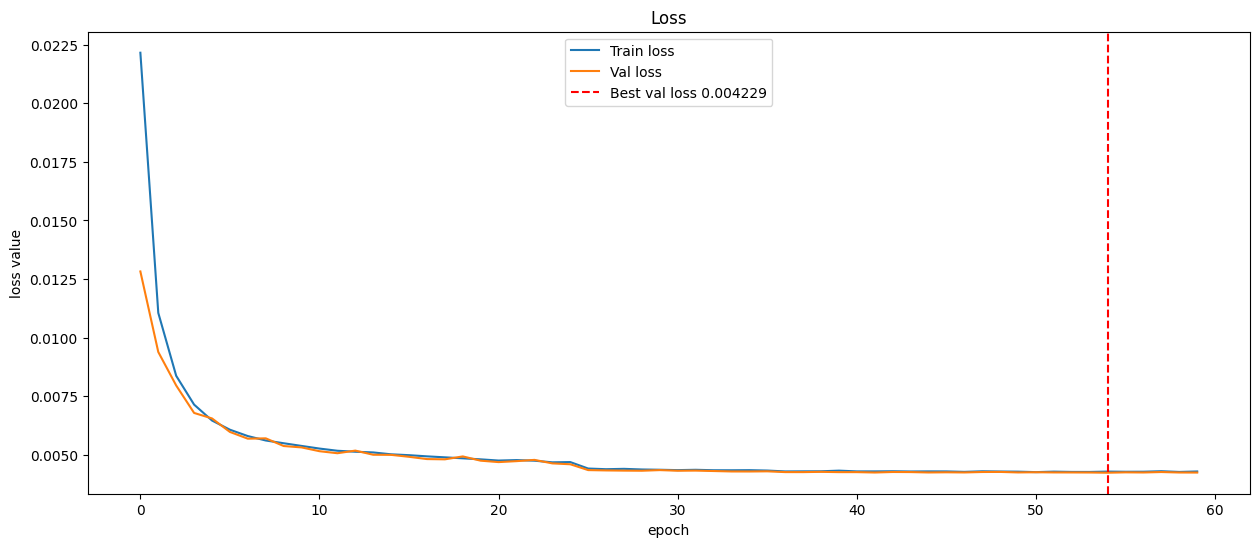

In [56]:
noise_factor = 0.5

denoiser = Autoencoder(dim_code).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW
denoiser, losses_denoiser = train_model(
    train_epoch_denoising,
    val_epoch_denoising,
    plot_outputs_denoising,
    plot_losses,
    [train_loader, val_loader],
    denoiser,
    optimizer,
    criterion,
    device,
    n_epochs=60,
    lr=1e-3,
    steps_scheduler=[25, 36, 50]
)

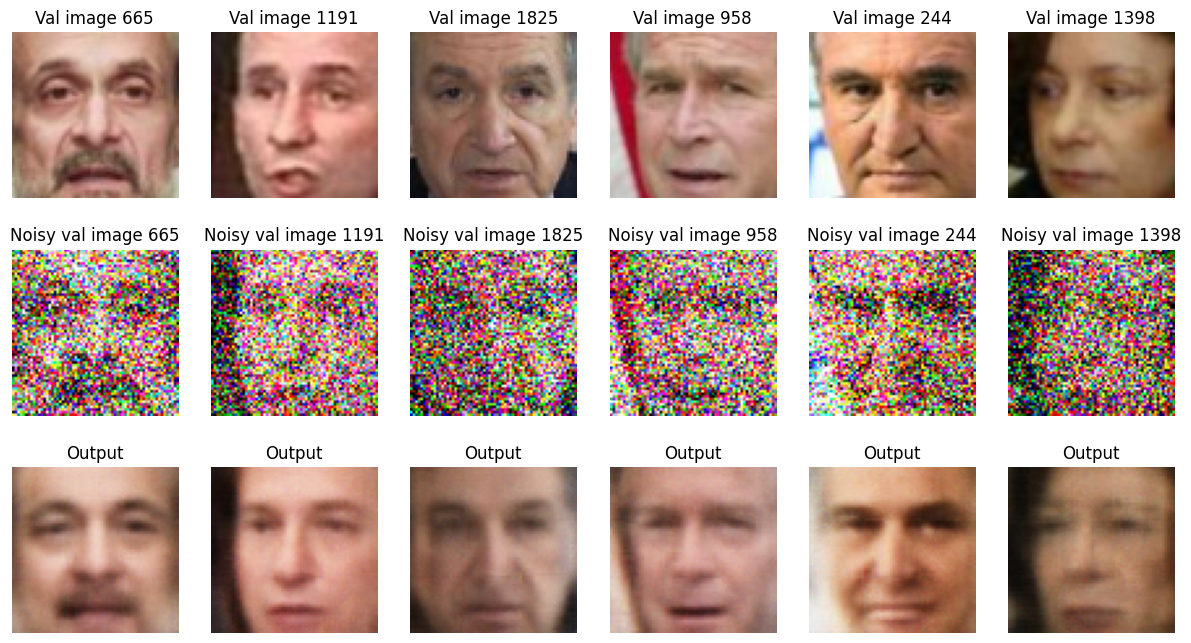

In [57]:
num_imgs = 6

fig, axes = plt.subplots(3, num_imgs, figsize=(15, 8))
denoiser.eval()
for i in range(num_imgs):
    k = np.random.randint(0, val_data.shape[0])
    img = val_data[k]
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Val image {k+1}')
    
    noisy_img = img + noise_factor * torch.randn_like(img)
    
    axes[1, i].imshow(noisy_img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Noisy val image {k+1}')
    
    with torch.no_grad():
        rec, _ = denoiser(noisy_img.to(device))
    
    axes[2, i].imshow(rec[0].detach().cpu())
    axes[2, i].axis('off')
    axes[2, i].set_title(f'Output')

Ну более-менее похоже)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

Для начала нужно обучить VAE на датасете из лиц (до этого он был обучен на цифрах).

In [58]:
def train_epoch_retriever(model, train_loader, optimizer, loss_fn, device):
    train_losses_per_epoch = []
    for X_batch in tqdm_notebook(train_loader, desc='Train', leave=False):
        X_batch = X_batch.to(device).permute(0, 3, 1, 2)
        optimizer.zero_grad()
        mu, logsigma, rec = model(X_batch)
        loss = loss_fn(X_batch, mu, logsigma, rec)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def val_epoch_retriever(model, val_loader, loss_fn, device):
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in tqdm_notebook(val_loader, desc='Validation', leave=False):
            X_batch = X_batch.to(device).permute(0, 3, 1, 2)
            mu, logsigma, rec = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, rec)
            val_losses_per_epoch.append(loss.item())
    return (
        np.mean(val_losses_per_epoch),
        X_batch.detach().cpu().permute(0, 2, 3, 1).numpy(),
        rec.detach().cpu().permute(0, 2, 3, 1).numpy()
    )

Пришлось немного увеличить размерность латентного вектора, а то совсем плохие реконструкции лиц получались.

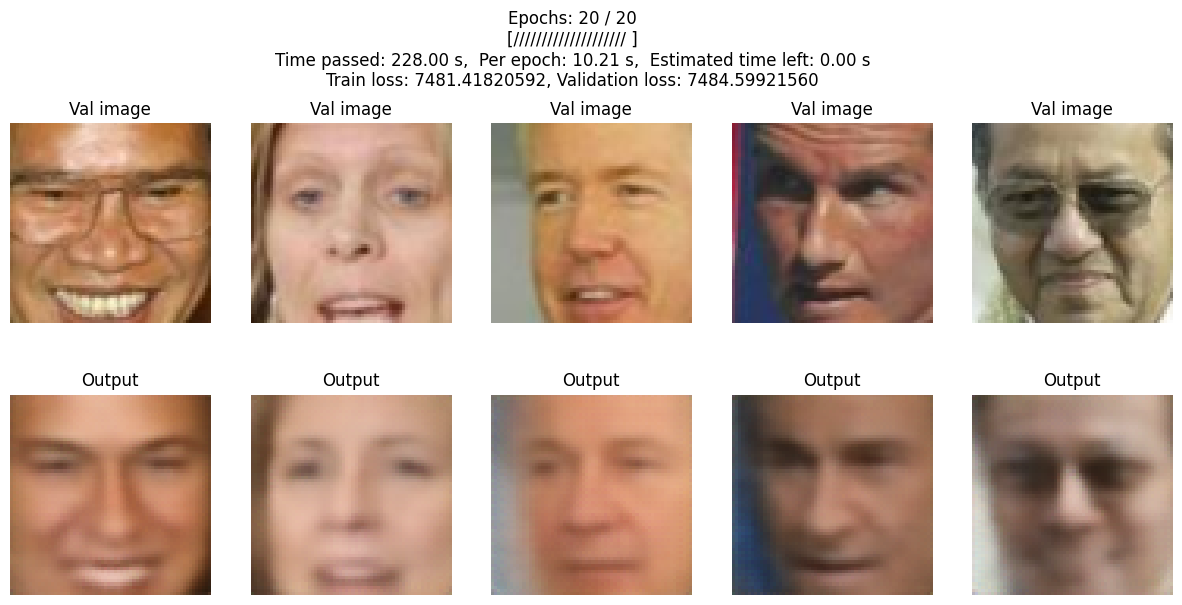

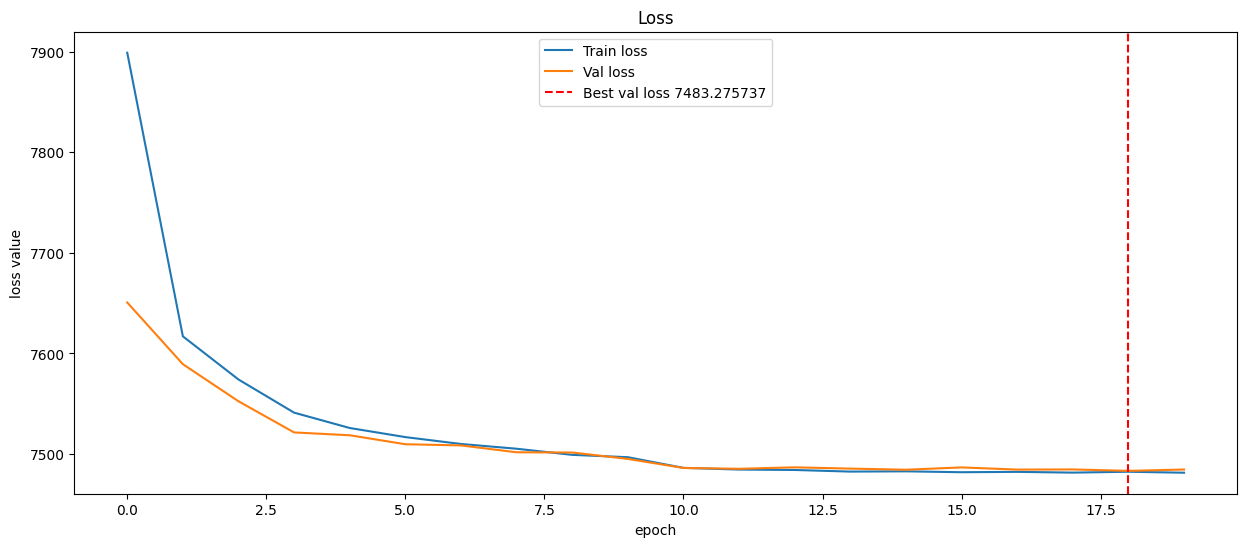

In [60]:
retriever = VAE(64, input_dim=3, img_size=64).to(device)
criterion = loss_vae
optimizer = optim.AdamW
retriever, _ = train_model(
    train_epoch_retriever,
    val_epoch_retriever,
    plot_outputs,
    plot_losses,
    [train_loader, val_loader],
    retriever,
    optimizer,
    criterion,
    device,
    n_epochs=20,
    lr=1e-3,
    steps_scheduler=[10, 14, 18]
)

In [61]:
# Создаем новый лоадер без перемешивания, чтобы потом доставать айдишники
new_train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    shuffle=False,
    num_workers=os.cpu_count()
)

In [62]:
retriever.eval()
codes = torch.tensor([])
with torch.no_grad():
    for X_batch in tqdm_notebook(new_train_loader):
        code, _ = retriever.encode(X_batch.to(device).permute(0, 3, 1, 2))
        codes = torch.cat((codes, code.detach().cpu()))
codes = codes.numpy()
print("Codes shape:", codes.shape)

  0%|          | 0/175 [00:00<?, ?it/s]

Codes shape: (11171, 64)


In [63]:
# Обучаем NearestNeighbors (LSHForest был удален из sklearn)
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_jobs=-1).fit(codes)

In [64]:
def get_similar(image, n_neighbors):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей
    retriever.eval()
    
    with torch.no_grad():
        code, _ = retriever.encode(image.to(device).permute(2, 0, 1).unsqueeze(0))

    (distances,),(idx,) = NN.kneighbors(code.detach().cpu().numpy(), n_neighbors=n_neighbors)
    
    return distances, train_data[idx]

In [65]:
def show_similar(image, n_neighbors=5):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances, neighbors = get_similar(image, n_neighbors)

    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.title("Original image")
    plt.show()

    fig, axes = plt.subplots(n_neighbors//5, 5, figsize=(15, n_neighbors//5*3+1))
    axes = axes.flatten()
    for i in range(n_neighbors):
        axes[i].imshow(neighbors[i])
        axes[i].set_title(f"Dist={distances[i]:.3f}")
    plt.show()

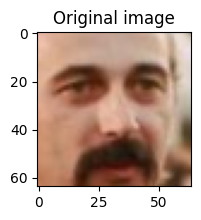

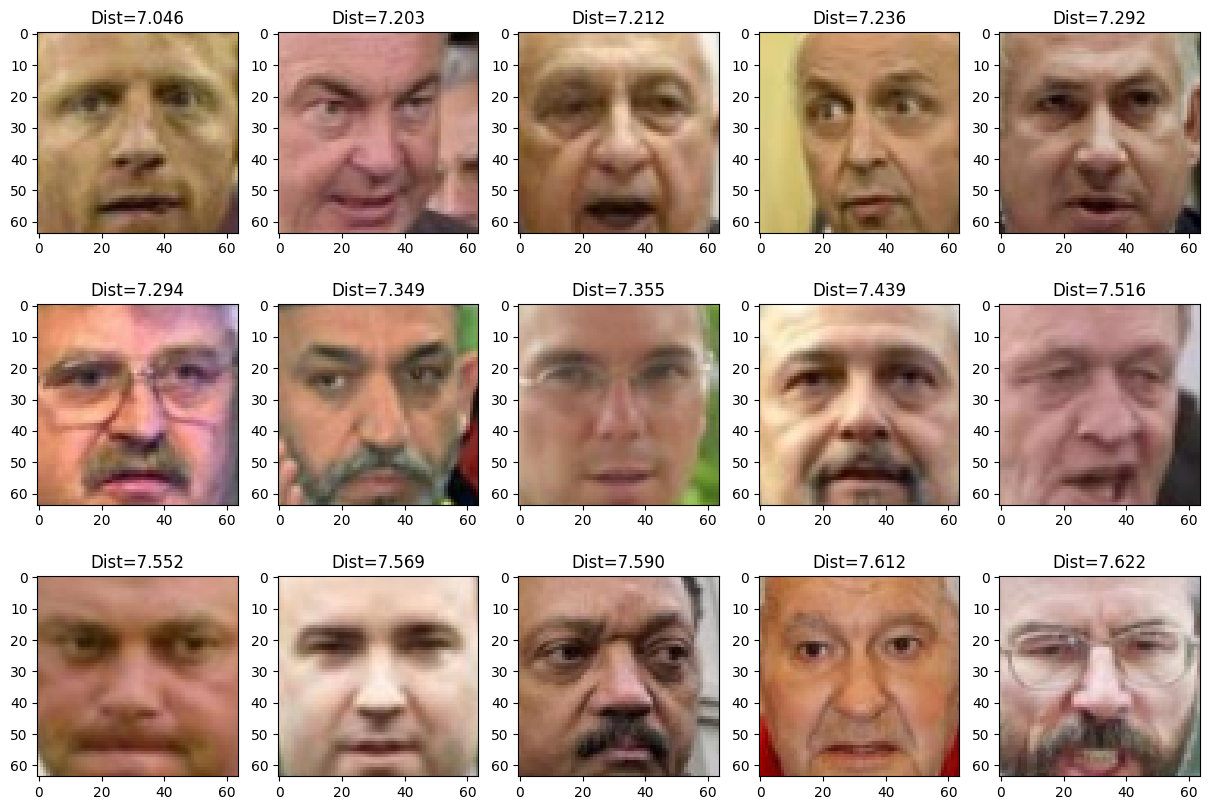

In [66]:
k = np.random.randint(0, val_data.shape[0])
show_similar(val_data[k], n_neighbors=np.random.choice(np.arange(5, 26, 5)))

Так-то довольно точно, если в трейн датасете был этот же человек, то он, по моим наблюдениям, попадает в топ 5-10 самых близких, чаще даже в топ 1-2. Да и остальные лица очень похожи на исходное.

Еще захотелось подать в новый vae векторы с нормальным стандартным распределением, посмотреть на отличия от ae)

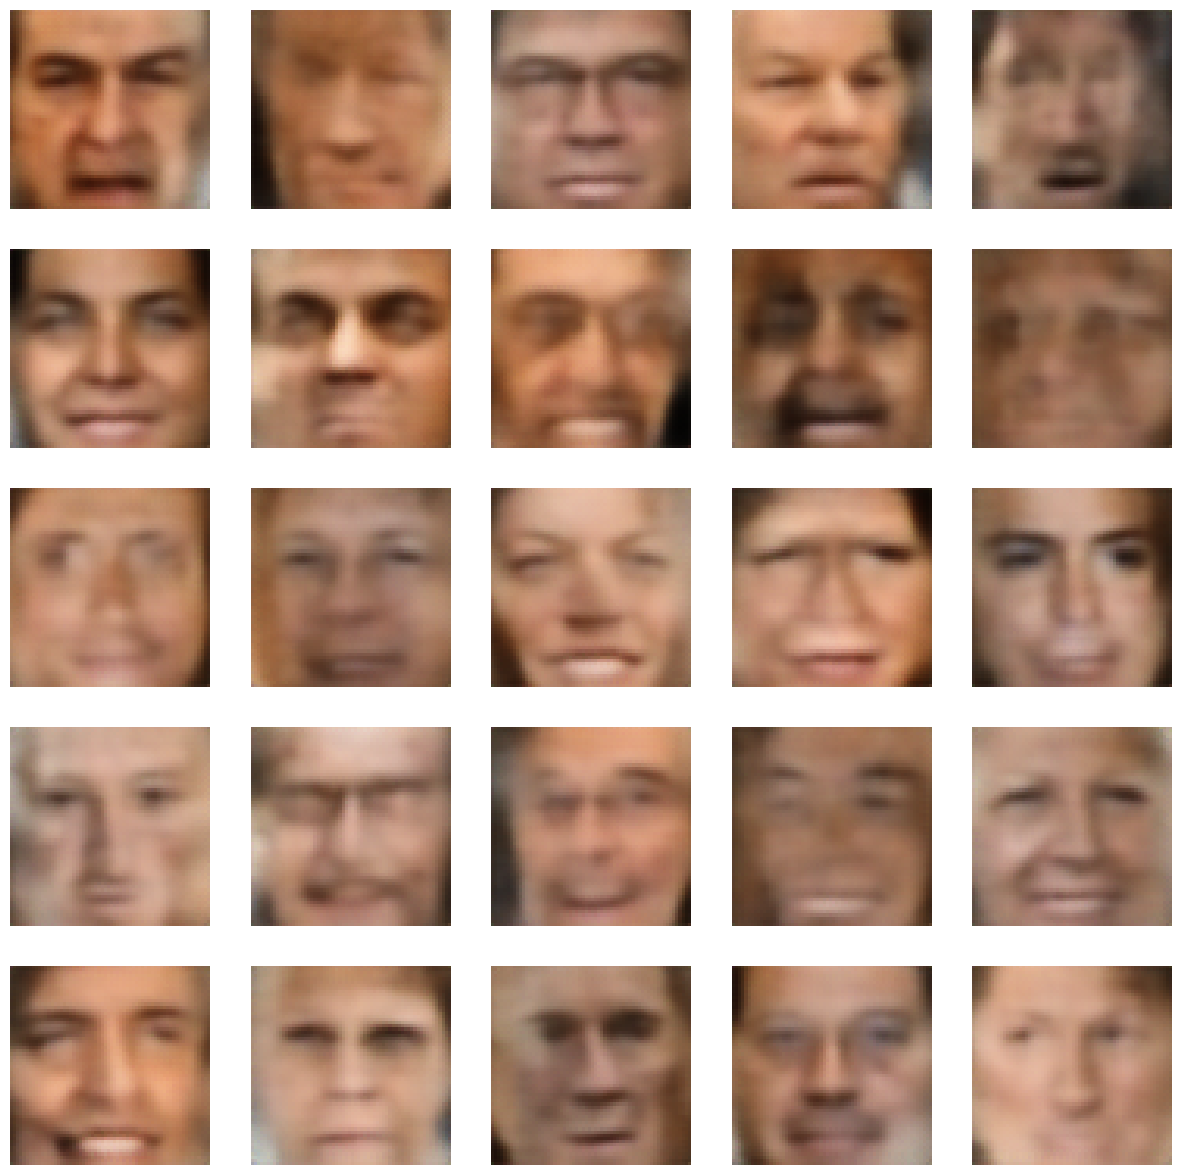

In [67]:
z = torch.randn((25, 64), dtype=torch.float)
retriever.eval()
with torch.no_grad():
    output = retriever.decode(z.to(device))

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()
for i, rec in enumerate(output):
    axes[i].imshow(rec.detach().cpu().squeeze(0).permute(1, 2, 0).numpy())
    axes[i].axis('off')

Изображения получились размытые, но намного лучше, чем у ae.